



# **Project n.2: Predict the energy efficiency of a building -  Classification**

## **1. Overall description of the machine learning task and motivation**



The goal of the project is to predict the performance of heating and cooling operations of the buildings, from a classification standpoint, based on simulated building energy aspects for which the simulation was created by [Tsanas et. al., 2012](https://www.sciencedirect.com/science/article/pii/S037877881200151X).

The dataset consists of the following variables:

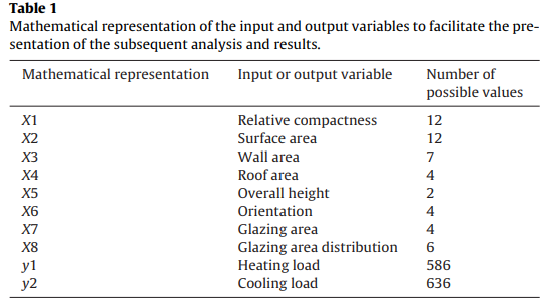


Table Credits: Tsanas et. al., 2012

Note: We have used 2 different approaches to turn Heating Load and Cooling load (which are continuous numerical variables) into binary and multiclass classification problems as per the task assigned to us. Then we have developed classification models as per two feature selection approaches.

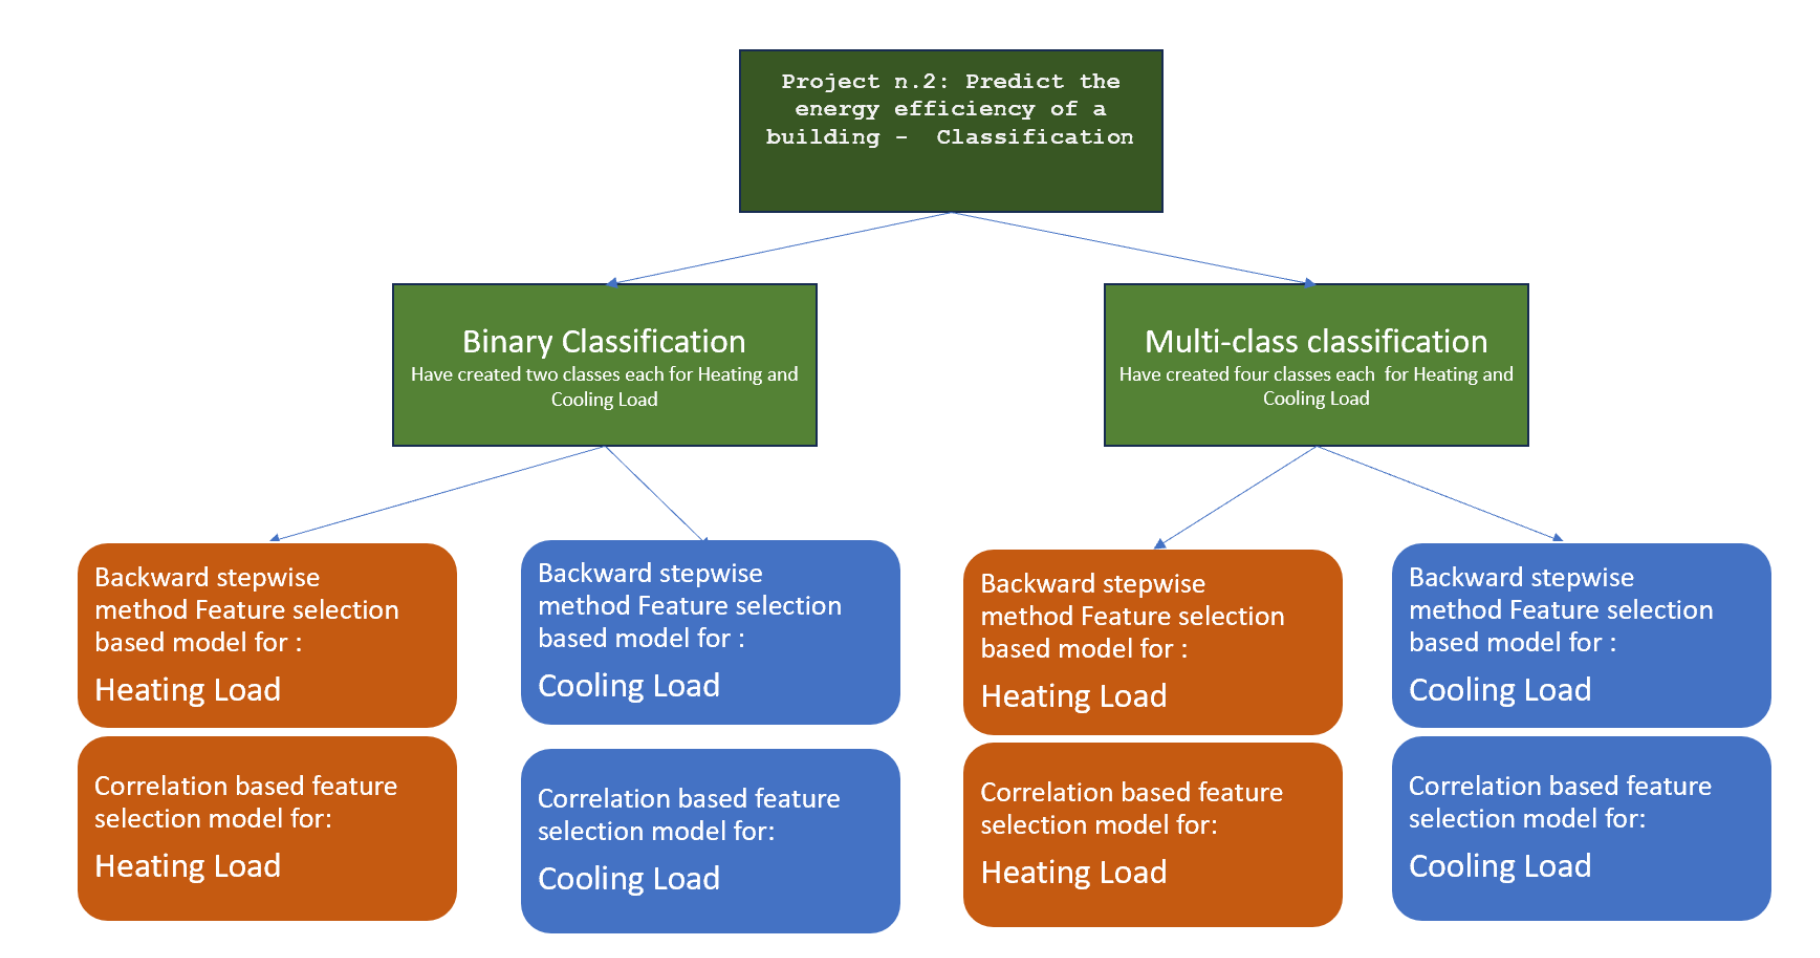

**The given notebook is divided into sections:**
1. **Data Analysis and Exploration**
2. **Machine Learning Models and Performance Assessment**
3. **Conclusion and Future Developments**

And each section is divided into subsections with their titles listed in the markdown.

The methodology flow in each subsection is as follows:
1. **Data Analysis and Exploration:**


*   After importing the necessary libraries and reading the dataset, we gather
statistical information about the data and do any necessary preprocessing (checking null values and removing duplicates etc).
*   We use a combination of plots to get an idea of the distribution of the data, see if there are any outliers and check the correlation between various features with respect to the target variable.
*   Feature selection: We use 2 different methods: backward stepwise method and correlation method to select a subset of features, create the filtered dataframes and then over the next sections compare how the 2 approaches perform.
*   Creation of binary and multiclass classification functions based on mean and quantiles respectively and performing some EDA on the newly created target variables to check for class imbalance and distribution.

2. **Machine Learning Models and Performance Assessment:**



*   We create a common training function which takes in the dataframe to be tested, the classification variable creation function and mapping. Then we use Nested holdout validation method to train the particular dataset (total 8 in number) with the Support Vector Classifier model from sklearn.
*   In the same function, we enable creation of a confusion matrix and some classification metrics in a report form to display thoroughly the performance of our approaches on the given dataset for classification.
*   We pass 8 of our datasets (2 classification approaches x 2 target variables x 2 feature selection approaches) through the above training function and display the metrics.

3. **Conclusion and Future Developments:**

*  We compared the classification metrics for different approaches and hypothesized why a certain approach should be preferred over the others used in this project. 
*  We mentioned some areas which can be explored as future development. 


Note: Inference is given under each subsection where a table or a plot is displayed.


### Importing the libraries needed and reading the excel sheet:

In [61]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, classification_report
%matplotlib inline

In [62]:
#reading data
data = pd.read_excel("./ENB2012_data.xlsx")

In [63]:
data.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [64]:
# Columns are renamed as per the convention given in dataset explaination paper
data = data.rename(columns={"X1": "RELATIVE COMPACTNESS",
                            "X2": "SURFACE AREA",
                            "X3": "WALL AREA",
                            "X4": "ROOF AREA",
                            "X5": "OVERALL HEIGHT",
                            "X6": "ORIENTATION",
                            "X7": "GLAZING AREA",
                            "X8": "GLAZING AREA DISTRIBUTION",
                            "Y1": "HEATING LOAD",
                            "Y2":"COOLING LOAD" })
data.head(5)

,RELATIVE COMPACTNESS,SURFACE AREA,WALL AREA,ROOF AREA,OVERALL HEIGHT,ORIENTATION,GLAZING AREA,GLAZING AREA DISTRIBUTION,HEATING LOAD,COOLING LOAD
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


## **2. Data analysis and Exploration:**


### Statistical information about the data:

In [65]:
data.describe().round(decimals=3)

,RELATIVE COMPACTNESS,SURFACE AREA,WALL AREA,ROOF AREA,OVERALL HEIGHT,ORIENTATION,GLAZING AREA,GLAZING AREA DISTRIBUTION,HEATING LOAD,COOLING LOAD
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,0.764,671.708,318.500,176.604,5.250,3.500,0.234,2.812,22.307,24.588
std,0.106,88.086,43.626,45.166,1.751,1.119,0.133,1.551,10.090,9.513
min,0.620,514.500,245.000,110.250,3.500,2.000,0.000,0.000,6.010,10.900
25%,0.682,606.375,294.000,140.875,3.500,2.750,0.100,1.750,12.992,15.620
50%,0.750,673.750,318.500,183.750,5.250,3.500,0.250,3.000,18.950,22.080
75%,0.830,741.125,343.000,220.500,7.000,4.250,0.400,4.000,31.668,33.132
max,0.980,808.500,416.500,220.500,7.000,5.000,0.400,5.000,43.100,48.030


</br>

### Detecting and dropping duplicate values (if any):

In [66]:
# finding duplicate values
duplicate_rows_newData = data[data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_newData.shape)

number of duplicate rows:  (0, 10)


In [67]:
data.count()

RELATIVE COMPACTNESS         768
SURFACE AREA                 768
WALL AREA                    768
ROOF AREA                    768
OVERALL HEIGHT               768
ORIENTATION                  768
GLAZING AREA                 768
GLAZING AREA DISTRIBUTION    768
HEATING LOAD                 768
COOLING LOAD                 768
dtype: int64

In [68]:
Main_data = data.drop_duplicates()
Main_data.count()

RELATIVE COMPACTNESS         768
SURFACE AREA                 768
WALL AREA                    768
ROOF AREA                    768
OVERALL HEIGHT               768
ORIENTATION                  768
GLAZING AREA                 768
GLAZING AREA DISTRIBUTION    768
HEATING LOAD                 768
COOLING LOAD                 768
dtype: int64

#### ***Inference:*** *No duplicate values found*.

</br>


### Checking for null or missing values:

In [69]:
print(Main_data.dtypes)


RELATIVE COMPACTNESS         float64
SURFACE AREA                 float64
WALL AREA                    float64
ROOF AREA                    float64
OVERALL HEIGHT               float64
ORIENTATION                    int64
GLAZING AREA                 float64
GLAZING AREA DISTRIBUTION      int64
HEATING LOAD                 float64
COOLING LOAD                 float64
dtype: object


In [70]:
print(Main_data.isnull().sum())

RELATIVE COMPACTNESS         0
SURFACE AREA                 0
WALL AREA                    0
ROOF AREA                    0
OVERALL HEIGHT               0
ORIENTATION                  0
GLAZING AREA                 0
GLAZING AREA DISTRIBUTION    0
HEATING LOAD                 0
COOLING LOAD                 0
dtype: int64


#### ***Inference:*** *No null values found and all columns are of the integer or float data-type*.  
</br>



### Checking for outliers using boxplots:

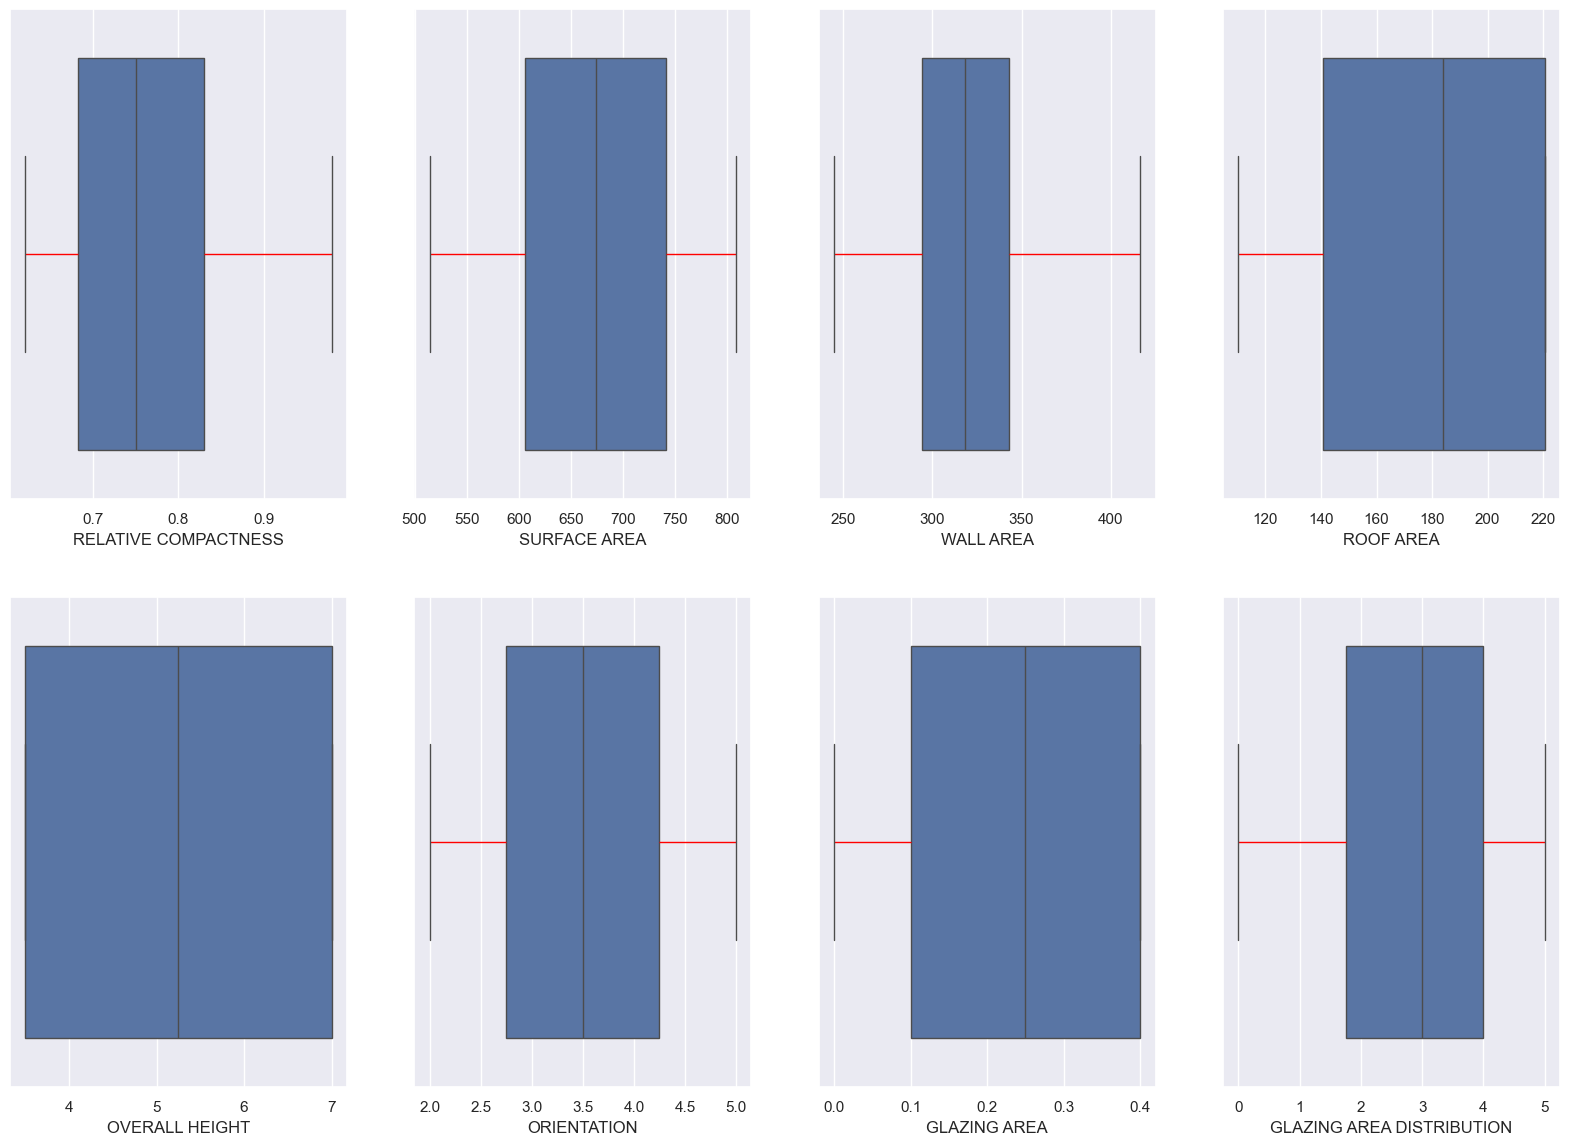

In [71]:
# creating list of independent variables (new X_list) after dropping target columns
X_list= ['RELATIVE COMPACTNESS', 'SURFACE AREA', 'WALL AREA', 'ROOF AREA', 'OVERALL HEIGHT', 'ORIENTATION', 'GLAZING AREA', 'GLAZING AREA DISTRIBUTION']
fig, axs = plt.subplots(nrows=2, ncols=4,  figsize=(20, 14))
for i, ax in enumerate(axs.flat):
    # Create a boxplot in each subplot for each predictor
    sns.boxplot(x=Main_data[X_list[i]], whiskerprops={'color': 'red'}, ax=ax)



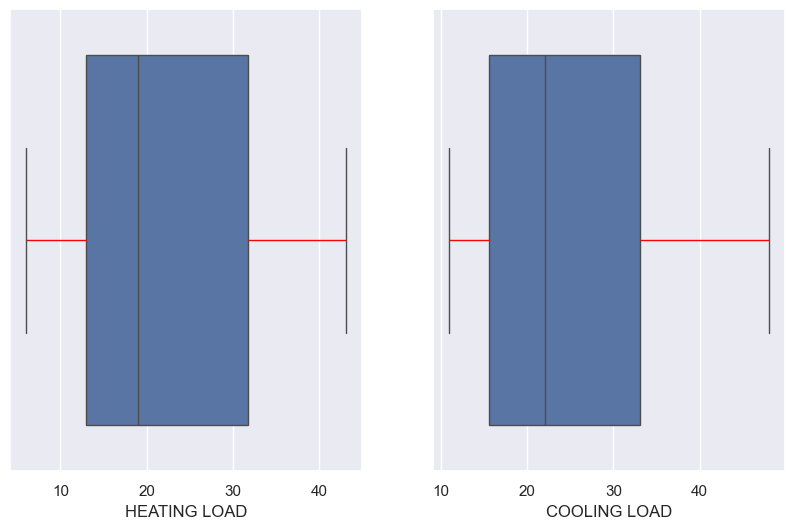

In [72]:
# plotting box plots for Target variables
Y_list = ['HEATING LOAD',	'COOLING LOAD']
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize=(10, 6))
for i, ax in enumerate(axs.flat):
    # Create a boxplot in each subplot for each target variable
    sns.boxplot(x=Main_data[Y_list[i]], whiskerprops={'color': 'red'}, ax=ax)

#### ***Inference:*** *No outliers found for Independent and Dependent variables.*
</br>



### Unique values in the dataframe:

In [73]:
for i in Main_data.columns:
  print(f"Number of unique values for {i} = ", Main_data[i].nunique())

Number of unique values for RELATIVE COMPACTNESS =  12
Number of unique values for SURFACE AREA =  12
Number of unique values for WALL AREA =  7
Number of unique values for ROOF AREA =  4
Number of unique values for OVERALL HEIGHT =  2
Number of unique values for ORIENTATION =  4
Number of unique values for GLAZING AREA =  4
Number of unique values for GLAZING AREA DISTRIBUTION =  6
Number of unique values for HEATING LOAD =  587
Number of unique values for COOLING LOAD =  636



#### ***Inference***: *What the data suggests about feature type*
1.   *Relative compactness: Discrete numerical variable*
2.   *Surface Area: Discrete numerical variable*
3.   *Wall area: Discrete numerical variable*
4.   *Roof Area: Discrete numerical variable*
5.   *Overall Height: Discrete numerical variable*
6.   *Orientation:  Discrete numerical variable*
7.   *Glazing Area: Discrete numerical variable*
8.   *Glazing Area Distribution: Discrete numerical variable*

7.   *Heating Load: Continuous numerical variable*
8.   *Cooling Load: Continuous numerical variable*

</br>


### Data visualization using histograms :


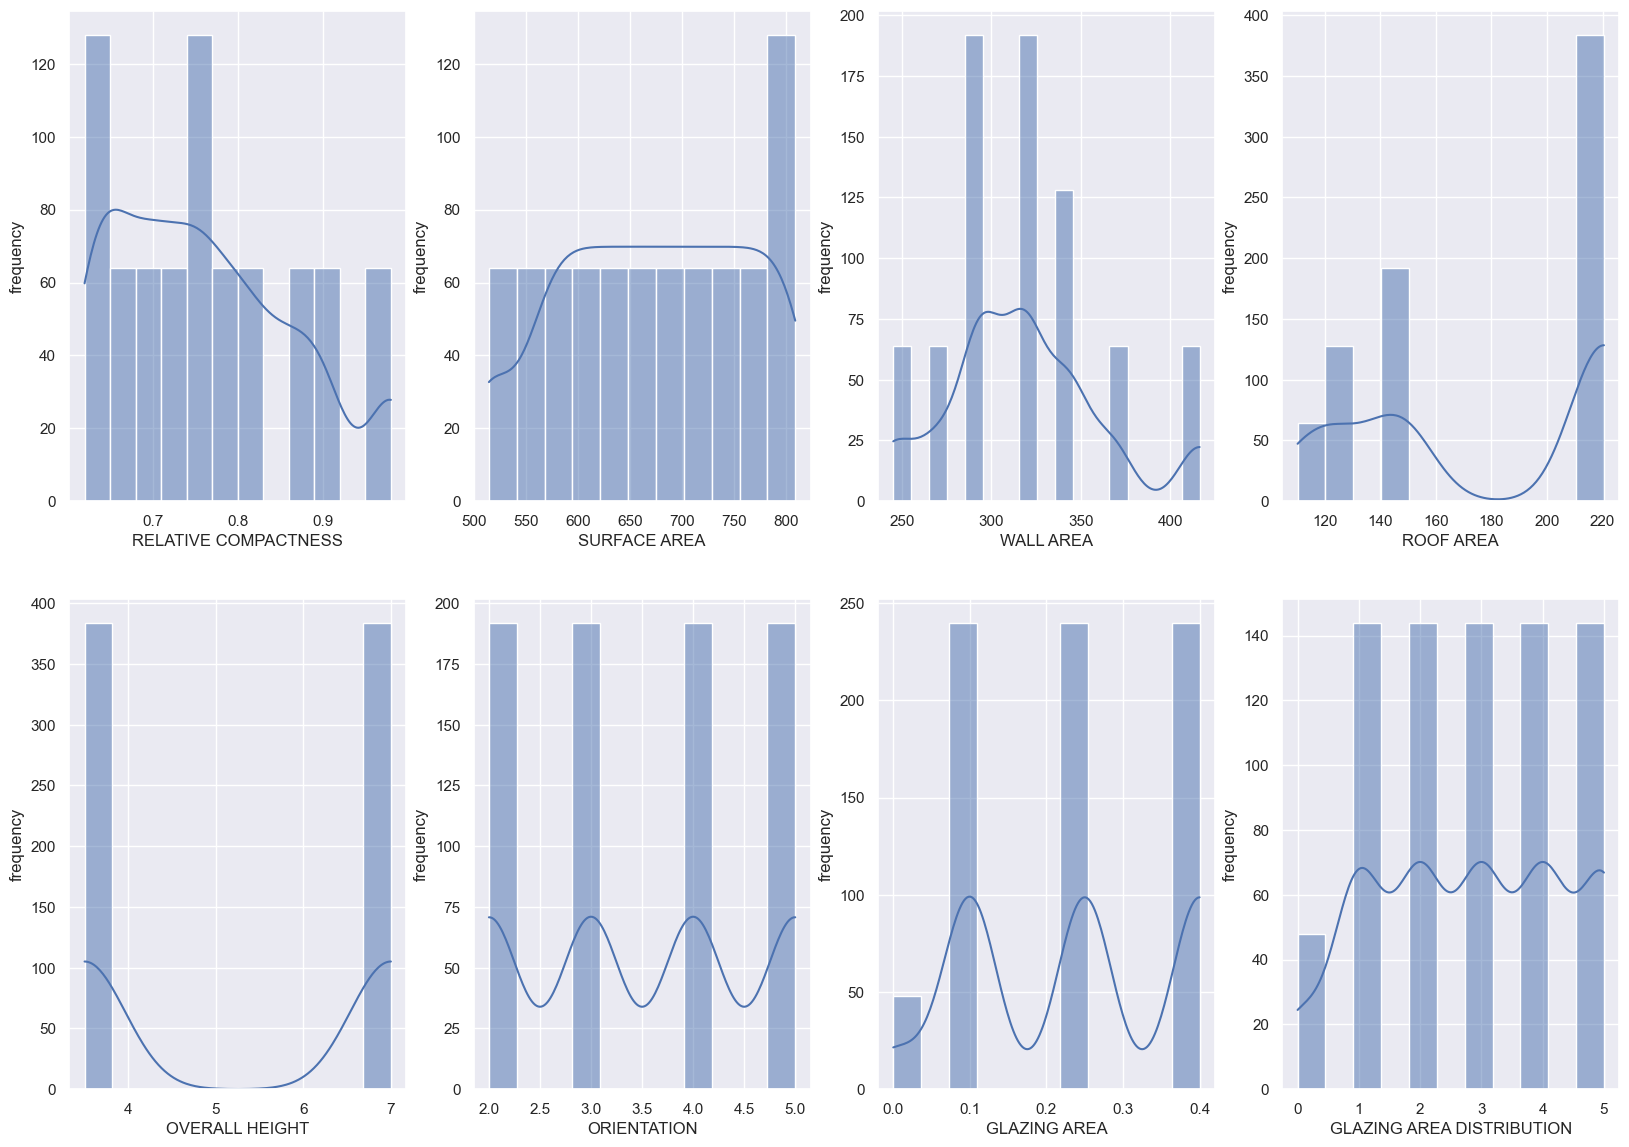

In [74]:
#Viewing distribution of the feature variables using histogram

X_list= ['RELATIVE COMPACTNESS', 'SURFACE AREA', 'WALL AREA', 'ROOF AREA', 'OVERALL HEIGHT', 'ORIENTATION', 'GLAZING AREA', 'GLAZING AREA DISTRIBUTION']
fig, axs = plt.subplots(nrows=2, ncols=4,  figsize=(20, 14))
for i, ax in enumerate(axs.flat):
    # Create a histplot for each subplot
    sns.histplot(data=data, x=X_list[i], ax=ax, kde=True)
    ax.set_ylabel("frequency")


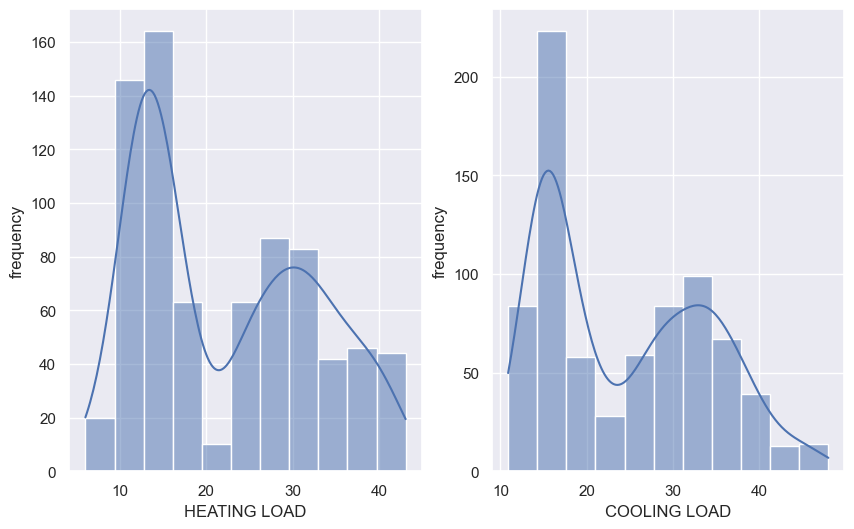

In [75]:
#Viewing distribution of the target variables using histogram

Y_list= ['HEATING LOAD', 'COOLING LOAD']
fig, axs = plt.subplots(ncols=2,  figsize=(10, 6))
for i, ax in enumerate(axs.flat):
    # Create a histplot for each subplot
    sns.histplot(data=data, x=Y_list[i], ax=ax, kde=True)
    ax.set_ylabel("frequency")

#### ***Inference:***

####    1. *The distribution does not seem like a Gaussian distribution (bell shaped).*
####    2. *Additionally, the target variables seem to have two peaks, hence we should provide scope for two classes based on frequency.*

</br>



### Finding the correlation between predictors and target variables:
*Note: We use Spearman's correlation since the data is non-Gaussian*

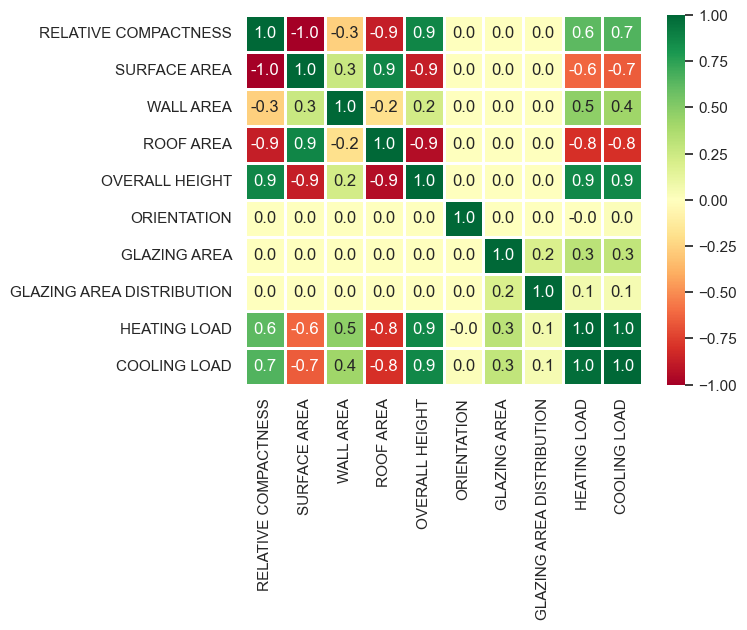

In [76]:
sns.heatmap(data.corr(method="spearman").round(decimals=2), cmap=plt.cm.RdYlGn, vmin=-1, vmax=1, annot=True, linewidths=2, fmt=".1f");

#### ***Inference:*** *From the heatmap, we see that cooling load and heating load have a very high correlation with each other and have similar correlation with features in the dataset. Thus we hypothesize that the different feature selection and modelling methodologies will yield similar results for both the target variables.*

### Visualising the relationship between predictors and the Heating Load using scatterplots:

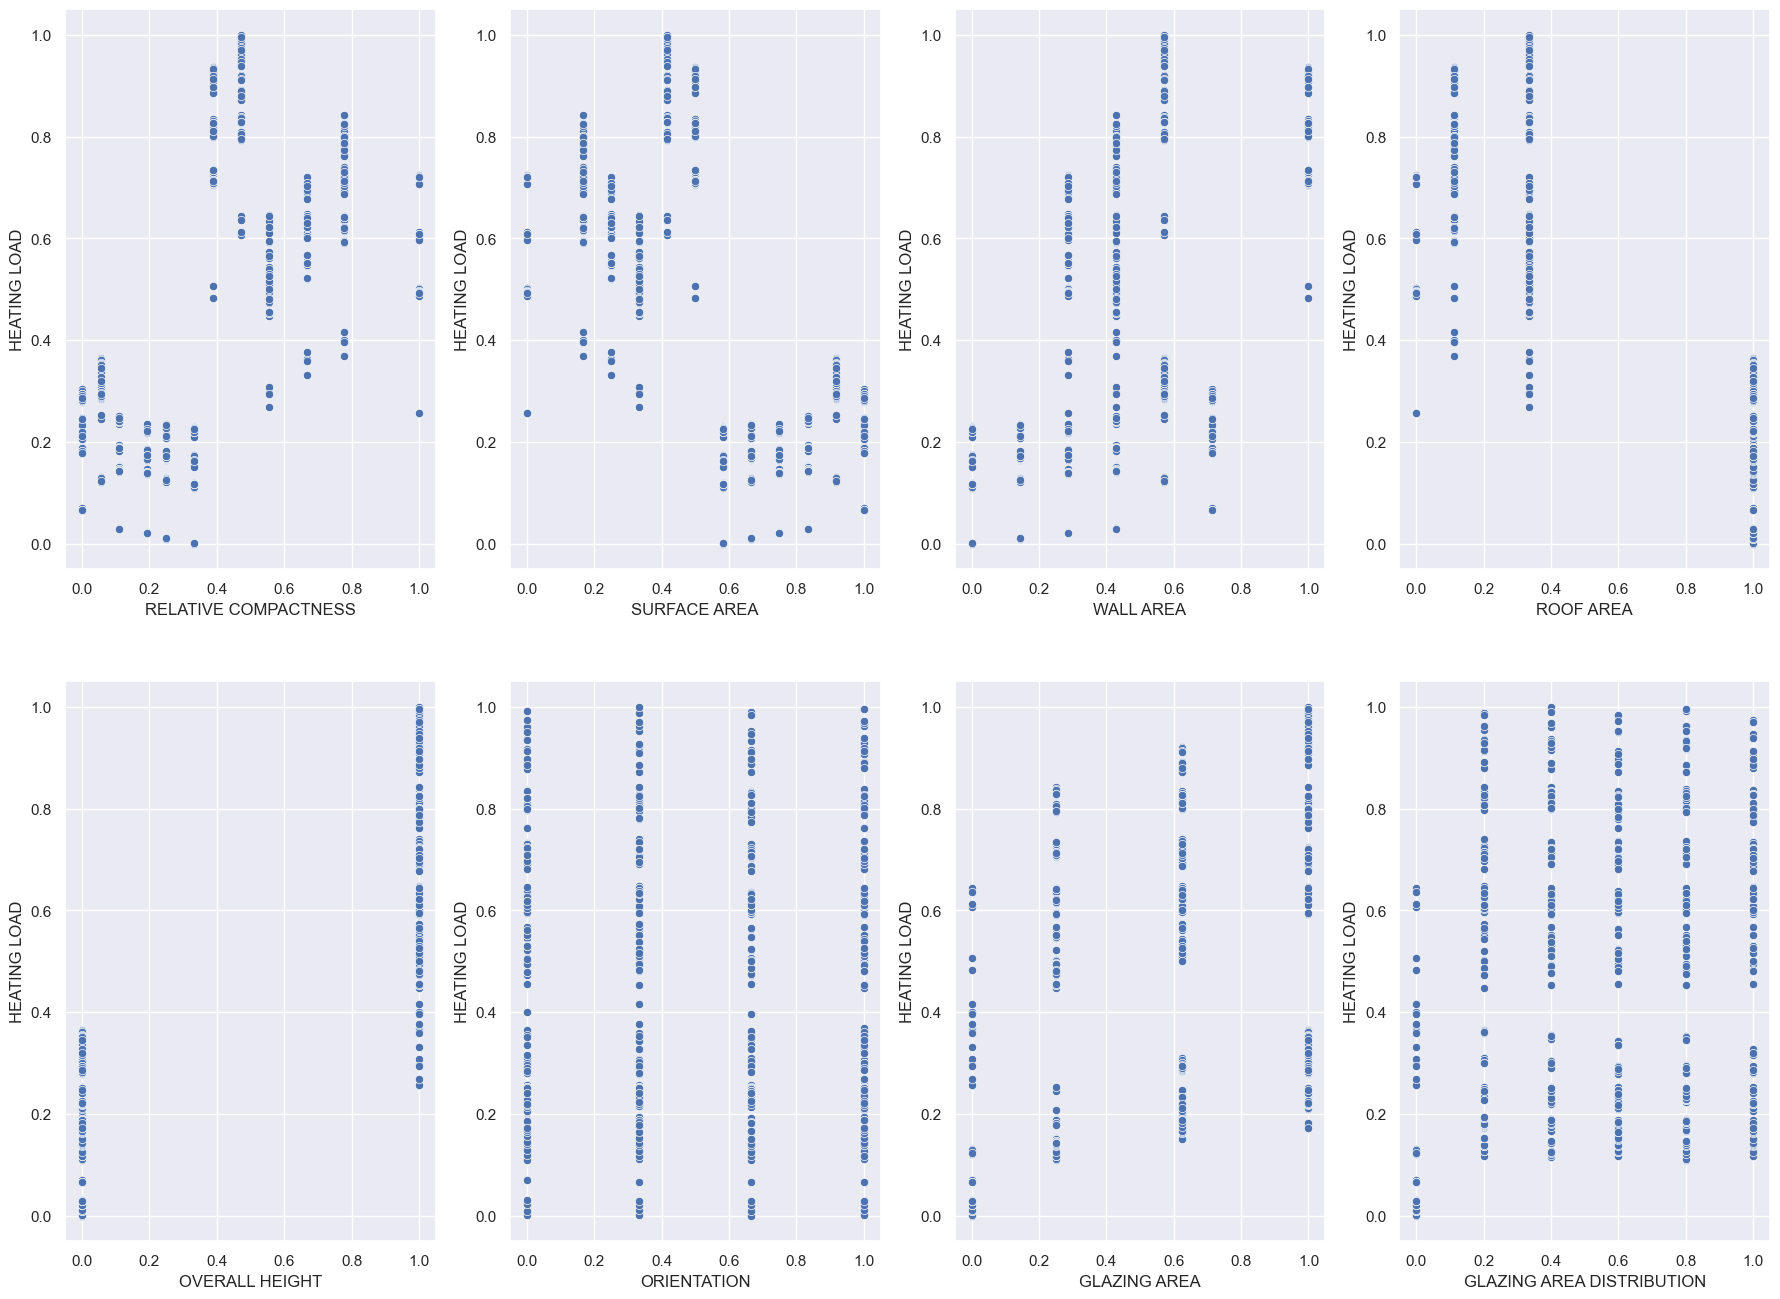

In [77]:
# Normalising data before plotting
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(Main_data)

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=Main_data.columns)

# defining layout for plotting
fig, axs = plt.subplots(nrows=2, ncols=4,  figsize=(22, 16))

for i, ax in enumerate(axs.flat):
    # Create a scatterplot in each subplot
    sns.scatterplot(data=normalized_df, x=normalized_df[X_list[i]], y='HEATING LOAD', ax=ax)
    ax.set_xlabel(X_list[i])
    ax.set_ylabel('HEATING LOAD')

### Visualising the relationship between predictors and the Cooling Load using scatterplots:

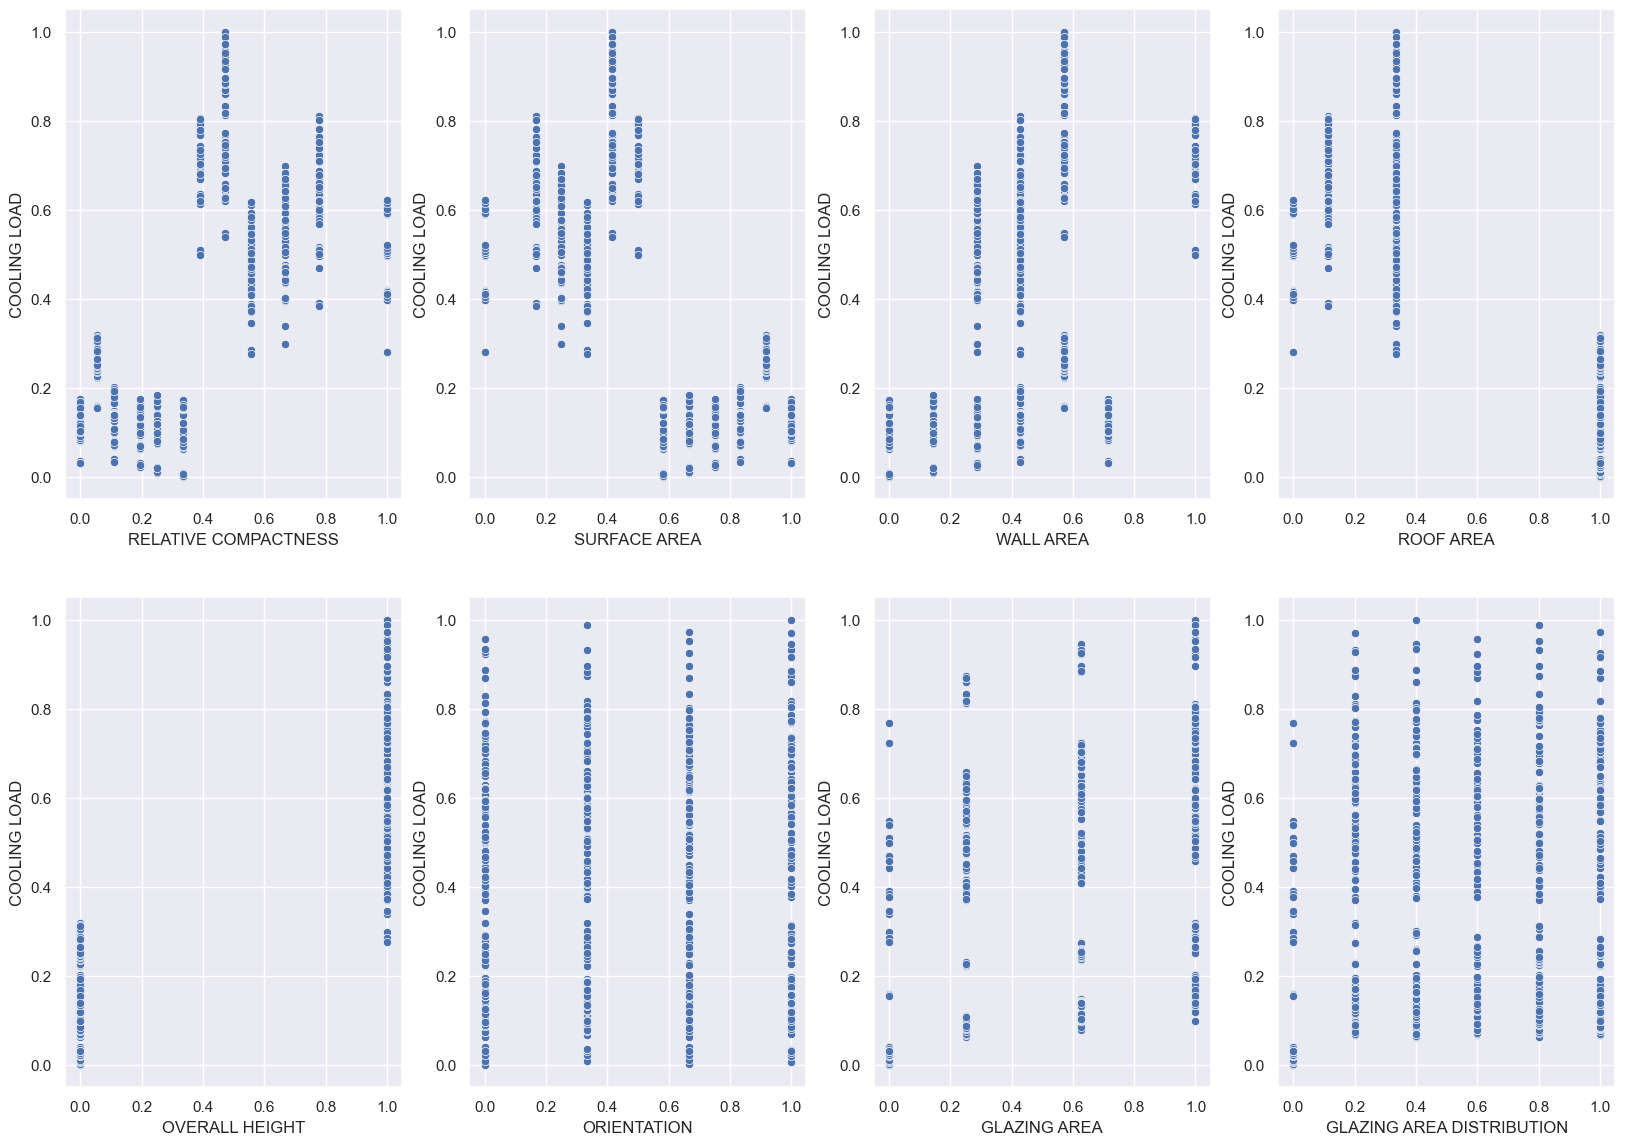

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=4,  figsize=(20, 14))
for i, ax in enumerate(axs.flat):
    # Create a scatterplot in each subplot
    sns.scatterplot(data=normalized_df, x=normalized_df[X_list[i]], y='COOLING LOAD', ax=ax)
    ax.set_xlabel(X_list[i])
    ax.set_ylabel('COOLING LOAD')

#### ***Inference:*** *From the scatterplots we can see that, using linear regression or a linear classification model in this data will be difficult due to lack of a linear relationship.*

### **Feature Selection**:

For feature selection two approaches has been tried:

1. Correlation based : Here we have selected those features which lie above a certain correlation threshold. Threshold considered is +/-0.2. The threshold depends on the industry/application. Usually a correlation below +/-0.2 is considered negligible hence it has been used to limit the features used in our model.This is done so as to improve the generalization ability of the model.

2. Backward stepwise method : Here we have selected those set of features as given by the Backward stepwise method. Backward stepwise method is used in those data sets where the number of features is considerably smaller than the number of observations of data. In this case the number of observation = 768, which is larger than the number of features we have = 8

In [79]:
Main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RELATIVE COMPACTNESS       768 non-null    float64
 1   SURFACE AREA               768 non-null    float64
 2   WALL AREA                  768 non-null    float64
 3   ROOF AREA                  768 non-null    float64
 4   OVERALL HEIGHT             768 non-null    float64
 5   ORIENTATION                768 non-null    int64  
 6   GLAZING AREA               768 non-null    float64
 7   GLAZING AREA DISTRIBUTION  768 non-null    int64  
 8   HEATING LOAD               768 non-null    float64
 9   COOLING LOAD               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


### Selecting features based on Correlation:


In [80]:
# Select features which show correlation coefficient with the target variable above a threshold.

features_corr_heating = Main_data.corr()["HEATING LOAD"][abs(Main_data.corr()["HEATING LOAD"])>(0.2)].index.tolist()
features_corr_cooling = Main_data.corr()["COOLING LOAD"][abs(Main_data.corr()["COOLING LOAD"])>(0.2)].index.tolist()
features_corr_heating = list(features_corr_heating[:len(features_corr_heating)-2])
features_corr_cooling = list(features_corr_cooling[:len(features_corr_cooling)-2])

# Display features selected by Correlation
print(features_corr_heating, features_corr_cooling)

['RELATIVE COMPACTNESS', 'SURFACE AREA', 'WALL AREA', 'ROOF AREA', 'OVERALL HEIGHT', 'GLAZING AREA'] ['RELATIVE COMPACTNESS', 'SURFACE AREA', 'WALL AREA', 'ROOF AREA', 'OVERALL HEIGHT', 'GLAZING AREA']


#### ***Inference:*** *Features which have a correlation more than +/-0.2 have been chosen for modelling.*
</br>

### Feature selection using Backward stepwise method:

In [81]:
# calculate mse
class Solution:
    features = list()
    mse = float('Inf')
    # Initialize the Solution class and initialize features and mse values whether on not they are passed as arguments
    def __init__(self, y, features=None, mse=None):
        if features and mse:
            self.features = features
            self.mse = mse
        else:
            pred = [y.mean()] * len(y)
            self.features = list()
            self.mse = mean_squared_error(y, pred)
    # Select the features based on lowest mse values
    def update(self, features, mse):
        if mse < self.mse:
            self.features = features
            self.mse = mse
            return True
        return False

In [82]:
def get_model(features):
    # make a pipeline with standardscalar normalizer and LR model
    return make_pipeline(
        ColumnTransformer(transformers=[
            ('numerical', StandardScaler(), features)
        ]),
        LinearRegression())

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

def backwardstepwise(current_features, x, y, best):
  # Implement backward stepwise method here by removing the feature that is absent in the model returning the lowest error.
  # Returns the best subset of features selected with low computational time.
  while len(current_features) > 0:
      removed_feature = None

      for feature in current_features:
          new_features = [f for f in current_features if f != feature]
          mses = cross_val_score(
              estimator=get_model(new_features),
              X=x[new_features], y=y, cv=kfold,
              scoring='neg_mean_squared_error')
          mse = -np.average(mses)
          if best.update(new_features, mse):
              removed_feature = feature
      if removed_feature:
          current_features.remove(removed_feature)
      else:
          break
  return best.features

In [83]:
# Select all features except the target variables
current_features= Main_data.columns
current_features= list(current_features[:len(current_features)-2])

In [84]:
X = Main_data[current_features]
y1 = Main_data["HEATING LOAD"]
y2 = Main_data["COOLING LOAD"]

# Initialize heating and cooling by passing the current list of features and MSE calculated on them
best_heating = Solution(
    y=y1,
    features=current_features,
    mse=-np.average(
        cross_val_score(
            estimator=get_model(current_features),
            X=X, y=y1, cv=kfold,
            scoring='neg_mean_squared_error')))

best_cooling = Solution(
    y=y2,
    features=current_features,
    mse=-np.average(
        cross_val_score(
            estimator=get_model(current_features),
            X=X, y=y2, cv=kfold,
            scoring='neg_mean_squared_error')))

In [85]:
stepwise_features_heating = backwardstepwise(current_features, X, y1, best_heating).copy()
stepwise_features_cooling = backwardstepwise(current_features, X, y2, best_cooling).copy()

# Display features selected by backward stepwise feature selection
print(stepwise_features_heating, stepwise_features_cooling)

['RELATIVE COMPACTNESS', 'SURFACE AREA', 'WALL AREA', 'ROOF AREA', 'OVERALL HEIGHT', 'ORIENTATION', 'GLAZING AREA', 'GLAZING AREA DISTRIBUTION'] ['RELATIVE COMPACTNESS', 'SURFACE AREA', 'WALL AREA', 'ROOF AREA', 'OVERALL HEIGHT', 'ORIENTATION', 'GLAZING AREA', 'GLAZING AREA DISTRIBUTION']


#### ***Inference:*** *Features which have lowest MSE in backward stepwise have been chosen. Additionally, since correlation between heating and cooling load is 1.0, both feature selection methods have selected the same features for both of them.*
</br>

### Comparing backward stepwise feature selection and correlation method:



In [86]:
unique_elements_stepwise = set(stepwise_features_cooling) - set(features_corr_cooling)
unique_elements_cooling = set(features_corr_cooling) - set(stepwise_features_cooling)
unique_elements_stepwise, unique_elements_cooling

({'GLAZING AREA DISTRIBUTION', 'ORIENTATION'}, set())

#### ***Inference:*** Backward stepwise method has kept all the features when it ran in our notebook while correlation has dropped 'Glazing Area Distribution' and 'Orientation' features.

Note: It is likely that for different environments, backward stepwise produces different MSEs (and hence different results) because of difference in initial weights and when the gradient descent has stopped. 

</br>

### Creating dataframes for each feature selection method

In [87]:
features_corr_heating.append("HEATING LOAD")
features_corr_cooling.append("COOLING LOAD")
stepwise_features_heating.append("HEATING LOAD")
stepwise_features_cooling.append("COOLING LOAD")

In [88]:
# Creating dataframes based on the lists of selected features
data_corr_heating = Main_data[features_corr_heating]
data_corr_cooling = Main_data[features_corr_cooling]

data_stepwise_heating = Main_data[stepwise_features_heating]
data_stepwise_cooling = Main_data[stepwise_features_cooling]

In [89]:
data_stepwise_heating.head()

,RELATIVE COMPACTNESS,SURFACE AREA,WALL AREA,ROOF AREA,OVERALL HEIGHT,ORIENTATION,GLAZING AREA,GLAZING AREA DISTRIBUTION,HEATING LOAD
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


In [90]:
data_stepwise_cooling.head()

,RELATIVE COMPACTNESS,SURFACE AREA,WALL AREA,ROOF AREA,OVERALL HEIGHT,ORIENTATION,GLAZING AREA,GLAZING AREA DISTRIBUTION,COOLING LOAD
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28


#### ***Inference:*** *We have 4 dataframes to experiment with, based on 2 feature selection approaches and 2 target variables.*

</br>

### **Binary and Multiclass Class Feature Creation:**

### Creation of binary classification target variable:

Class creation rule:

Creating two classes named 'Low' and 'High' based on the mean of the target variable values. Those observations greater than the mean of target variables is considered as 'Low' and 'High' otherwise.



In [91]:
# Function to classify target variables based on the mean value. Low if "less" than mean value, otherwise "high"
def binary_classify(input_series):
    mean_value = input_series.mean()
    input_series_new = input_series.apply(lambda x: 1 if x > mean_value else 0)
    return input_series_new

In [92]:
class_label_mapping_bin = {0:"Low", 1:"High"}

data_corr_heating_bin = data_corr_heating.copy(deep=True)
data_corr_cooling_bin = data_corr_cooling.copy(deep=True)

In [93]:
data_corr_heating_bin["Heating_Load_Binary"]= binary_classify(data_corr_heating_bin["HEATING LOAD"])
data_corr_cooling_bin["Cooling_Load_Binary"]= binary_classify(data_corr_cooling_bin["COOLING LOAD"])

data_corr_heating_bin['HL_Class_label'] = data_corr_heating_bin['Heating_Load_Binary'].map(class_label_mapping_bin)
data_corr_cooling_bin['CL_Class_label'] = data_corr_cooling_bin['Cooling_Load_Binary'].map(class_label_mapping_bin)

### Visualizaton of classes - Binary

Note: Since both feature selection approaches dataframes have same target classification variable values, we will visualize only one set of dataframes here (That is: Correlation dataframes will show target class distribution which will be same as Backward stepwise selection dataframe, hence we use only correlation dataframe for visualization here)

Text(0, 0.5, 'Frequency')

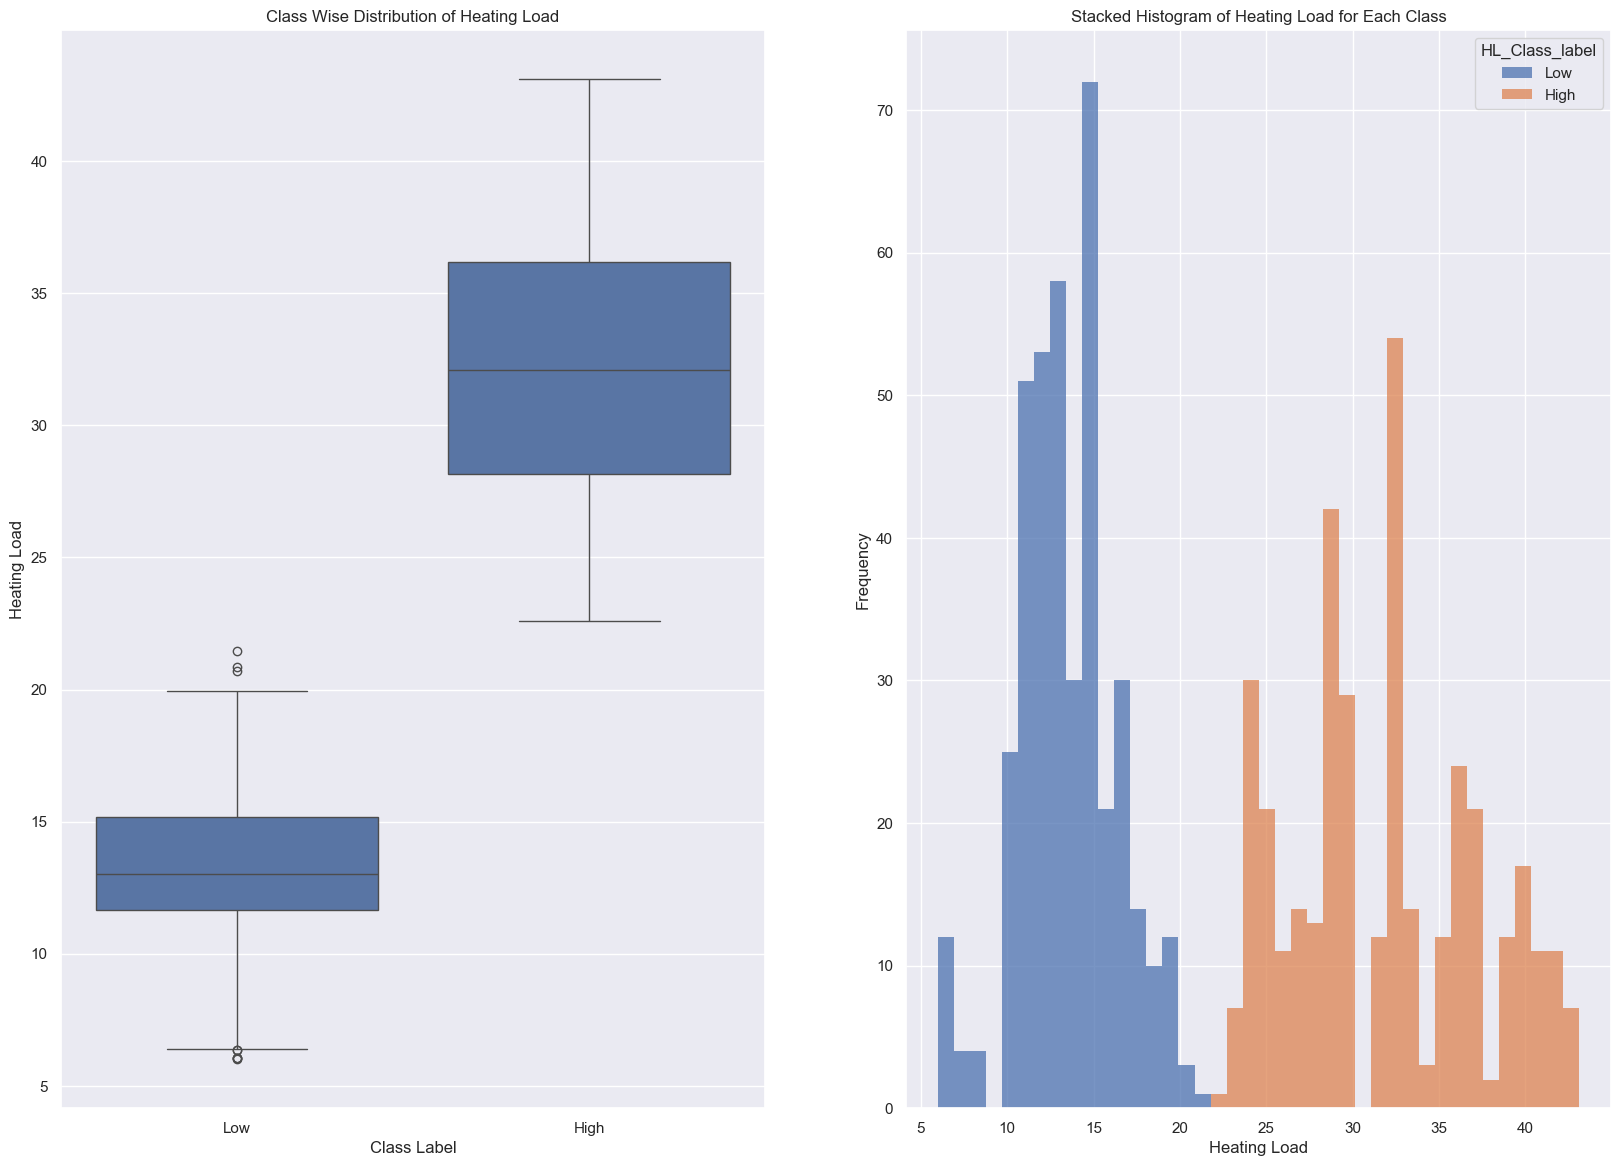

In [94]:
# plotting to observe distribution of Heating load as per the binary classification rule used
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize=(20, 14))
sns.boxplot(x='HL_Class_label', y='HEATING LOAD', data=data_corr_heating_bin, ax=axs[0])
axs[0].set_title('Class Wise Distribution of Heating Load')
axs[0].set_xlabel('Class Label')
axs[0].set_ylabel('Heating Load')


sns.histplot(data=data_corr_heating_bin, x='HEATING LOAD', hue='HL_Class_label', multiple='stack', bins=40, linewidth=0, ax=axs[1])#, palette=['yellow', 'black', 'black','black'])
axs[1].set_title('Stacked Histogram of Heating Load for Each Class')
axs[1].set_xlabel('Heating Load')
axs[1].set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

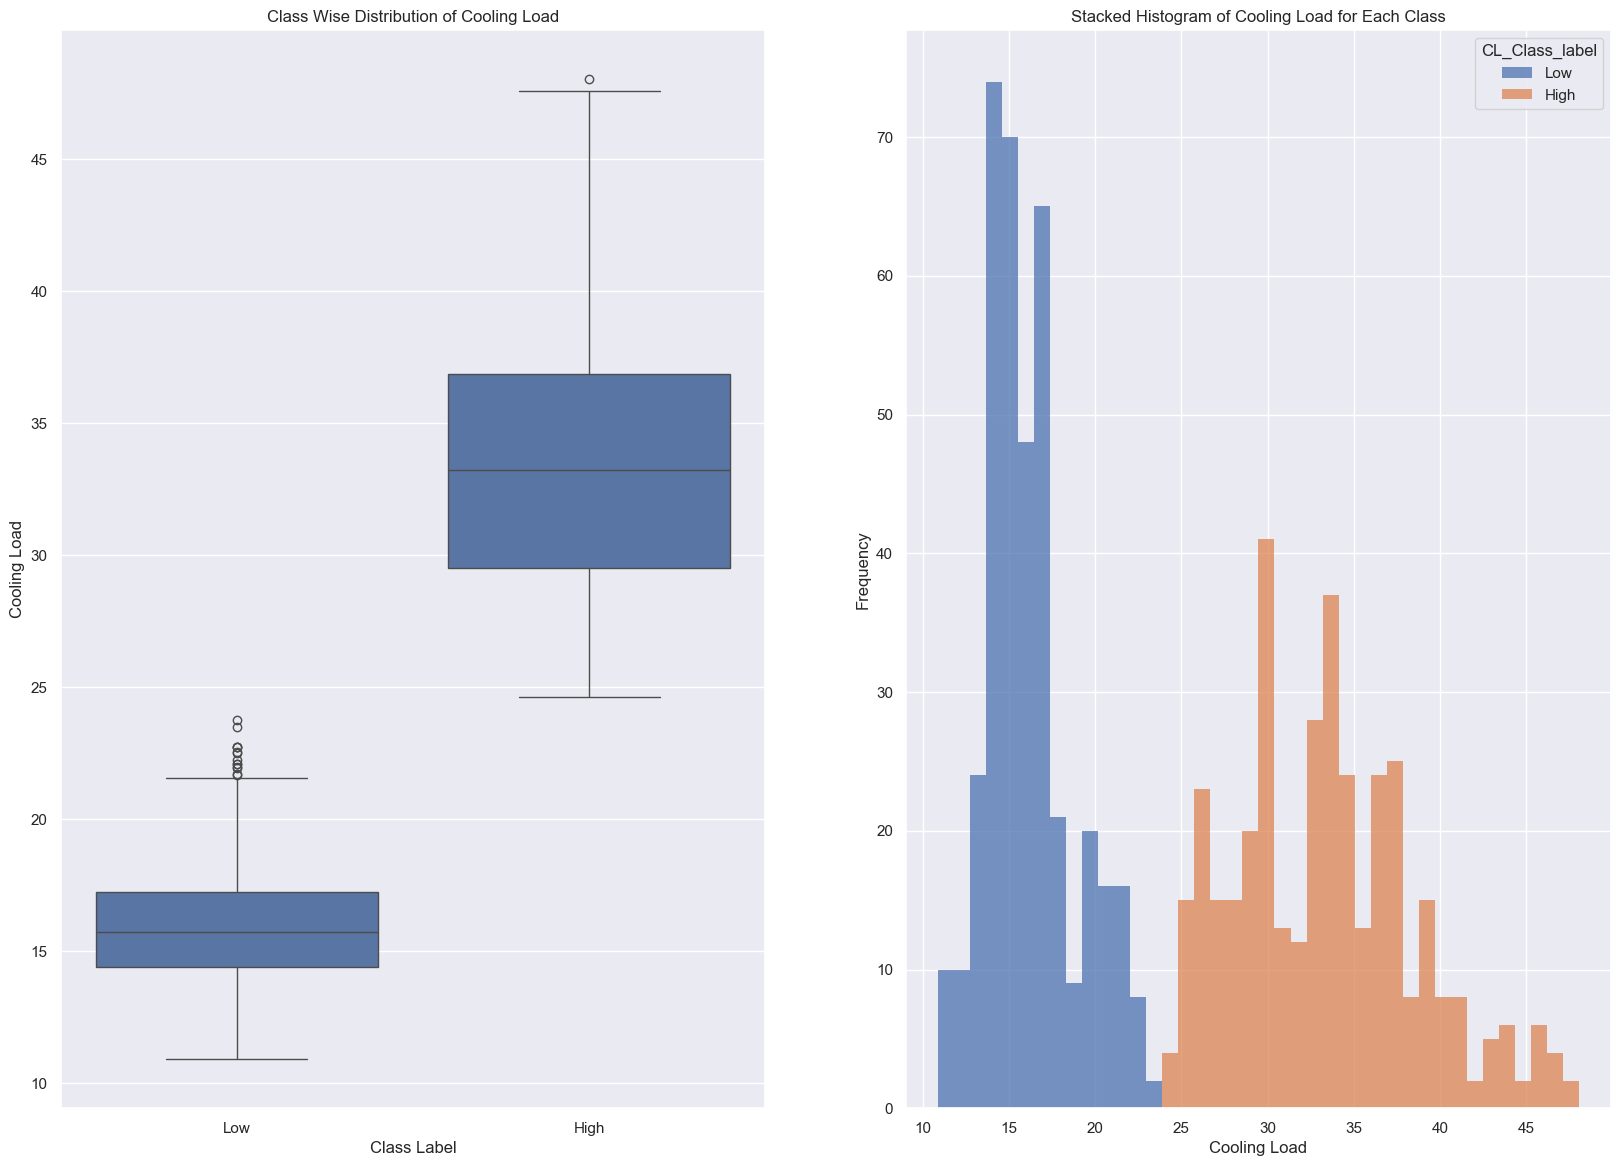

In [95]:
# plotting to observe distribution of Cooling load as per the binary classification rule used
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize=(20, 14))
sns.boxplot(x='CL_Class_label', y='COOLING LOAD', data=data_corr_cooling_bin, ax=axs[0])
axs[0].set_title('Class Wise Distribution of Cooling Load')
axs[0].set_xlabel('Class Label')
axs[0].set_ylabel('Cooling Load')


sns.histplot(data=data_corr_cooling_bin, x='COOLING LOAD', hue='CL_Class_label', multiple='stack', bins=40, linewidth=0, ax=axs[1])#, palette=['yellow', 'black', 'black','black'])
axs[1].set_title('Stacked Histogram of Cooling Load for Each Class')
axs[1].set_xlabel('Cooling Load')
axs[1].set_ylabel('Frequency')

Text(0.5, 1.0, 'Cooling Load Class Distribution')

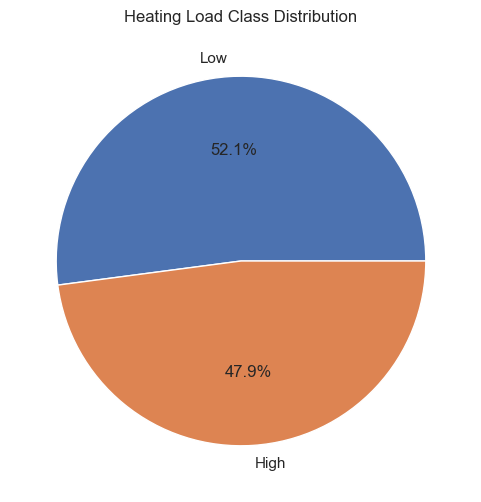

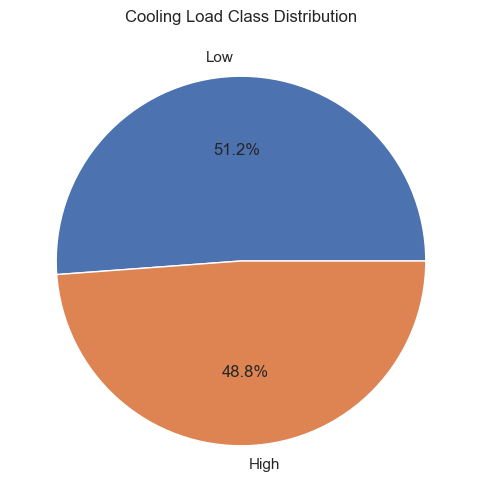

In [96]:
# plotting pie-chart for Binary classification problem for both the target variables
plt.figure(figsize=(6, 6))
palette_color = sns.color_palette('bright')
plt.pie(data_corr_heating_bin['Heating_Load_Binary'].value_counts(), labels=data_corr_heating_bin['HL_Class_label'].value_counts().index, autopct='%1.1f%%')
plt.title('Heating Load Class Distribution')

plt.figure(figsize=(6, 6))
palette_color = sns.color_palette('bright')
plt.pie(data_corr_cooling_bin['Cooling_Load_Binary'].value_counts(), labels=data_corr_cooling_bin['CL_Class_label'].value_counts().index, autopct='%1.1f%%')
plt.title('Cooling Load Class Distribution')

#### ***Inference:***
1. *From the classwise distribution, we can see a clear distinction between the 2 created classes. While the frequency of class 'Low' may seem higher, the spread of class 'High' is wider as per the histogram*
2. *From the pie chart, we can see that the classes are balanced*

### Creation of multiclass classification target variable

Class creation rule: Creating four classes named 'Q1', 'Q2'. 'Q3' and 'Q4' based on the quantiles in which the target variable values lie individually.

In [97]:
# Function to classify target variables based on the 4 Quantiles. The classes will be Q1, Q2, Q3, Q4
def multi_classify(input_series):
  num_classes = 4
  quantile_values = pd.qcut(input_series, q=num_classes, labels=range(1, num_classes + 1), retbins=True)[1]
  print("The quantiles are: ", quantile_values)
  input_series_new= pd.qcut(input_series, q=num_classes, labels=range(1, num_classes + 1))
  return input_series_new

In [98]:
# Create a new column "Class_Load" based on quantiles
class_label_mapping_multi = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}

data_corr_heating_multi = data_corr_heating.copy(deep=True)
data_corr_cooling_multi = data_corr_cooling.copy(deep=True)

In [99]:
data_corr_heating_multi["HL_Class_Multi"]= multi_classify(data_corr_heating_multi["HEATING LOAD"])
data_corr_cooling_multi["CL_Class_Multi"]= multi_classify(data_corr_cooling_multi["COOLING LOAD"])

data_corr_heating_multi['HL_Class_label_Multi'] = data_corr_heating_multi['HL_Class_Multi'].map(class_label_mapping_multi)
data_corr_cooling_multi['CL_Class_label_Multi'] = data_corr_cooling_multi['CL_Class_Multi'].map(class_label_mapping_multi)

The quantiles are:  [ 6.01   12.9925 18.95   31.6675 43.1   ]
The quantiles are:  [10.9    15.62   22.08   33.1325 48.03  ]


In [100]:
data_corr_heating_multi.head()

,RELATIVE COMPACTNESS,SURFACE AREA,WALL AREA,ROOF AREA,OVERALL HEIGHT,GLAZING AREA,HEATING LOAD,HL_Class_Multi,HL_Class_label_Multi
0,0.98,514.5,294.0,110.25,7.0,0.0,15.55,2,Q2
1,0.98,514.5,294.0,110.25,7.0,0.0,15.55,2,Q2
2,0.98,514.5,294.0,110.25,7.0,0.0,15.55,2,Q2
3,0.98,514.5,294.0,110.25,7.0,0.0,15.55,2,Q2
4,0.90,563.5,318.5,122.50,7.0,0.0,20.84,3,Q3


### Visualizaton of classes - Multiclass

Note: Since both feature selection approaches dataframes have same target classification variable values, we will visualize only one set of dataframes here (That is: Correlation dataframes will show target class distribution which will be same as Backward stepwise selection dataframe, hence we use only correlation dataframe for visualization here)

Text(0, 0.5, 'Frequency')

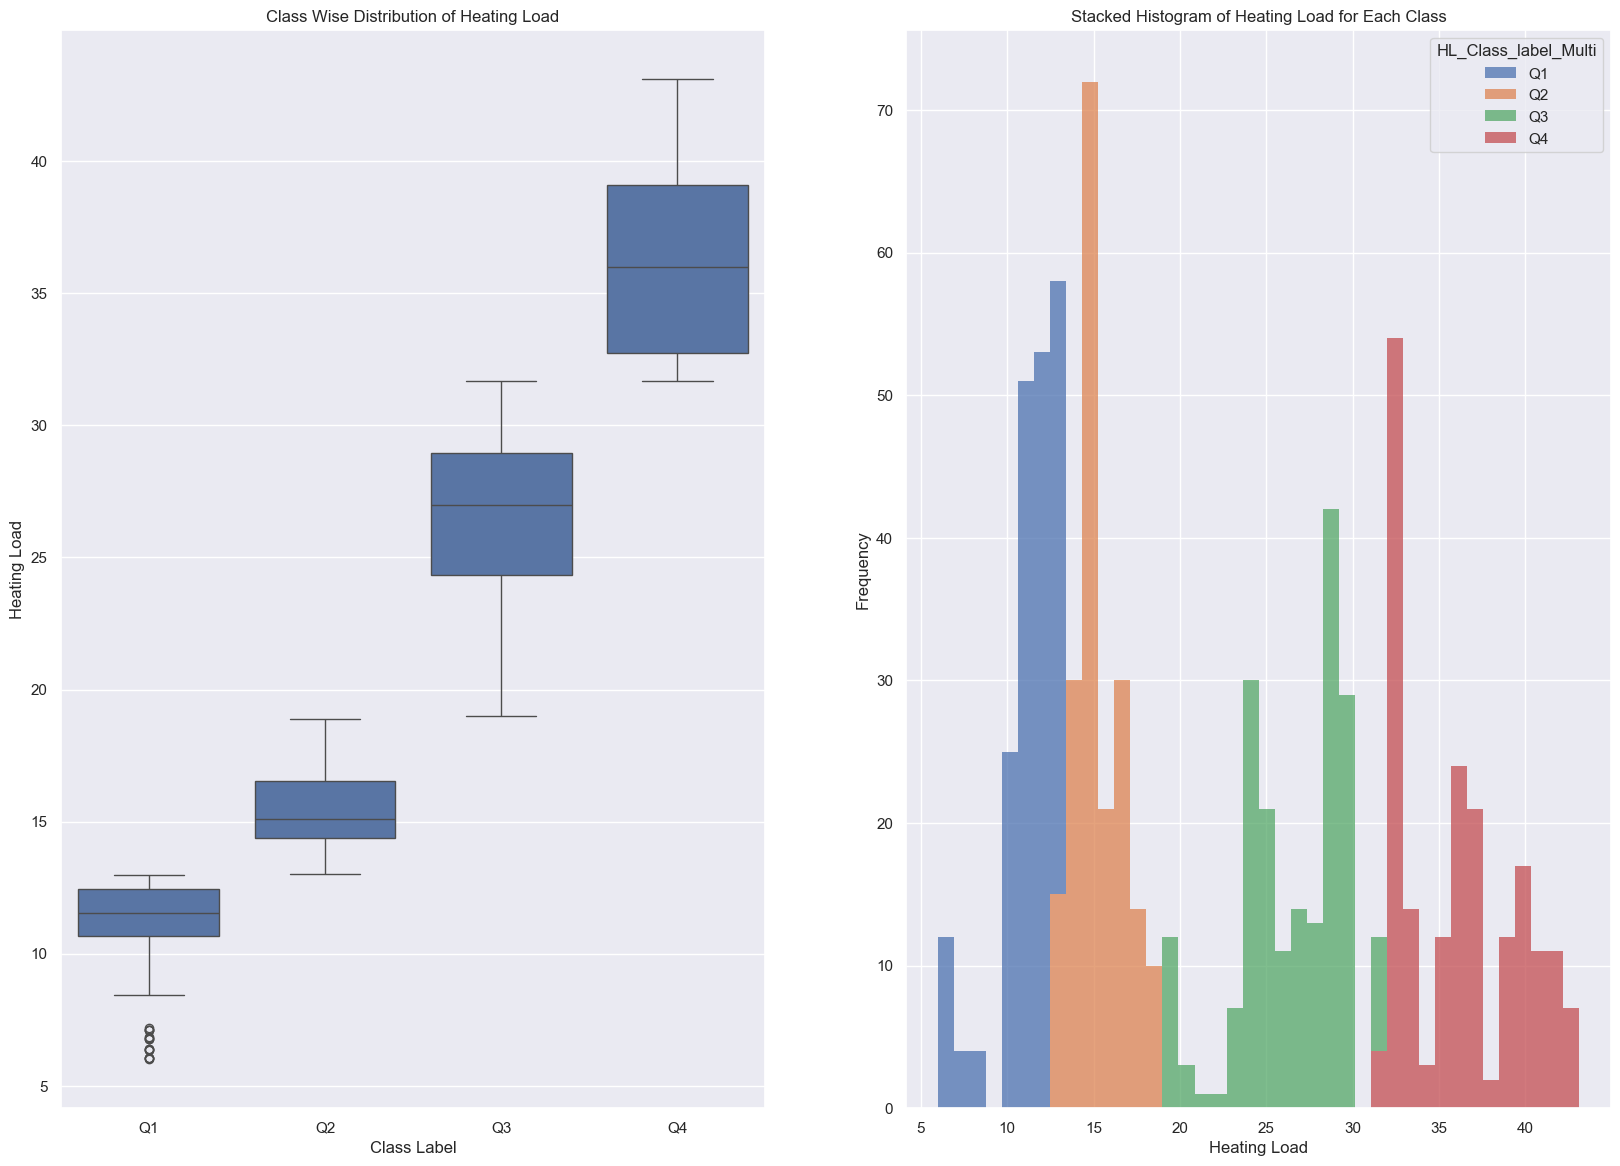

In [101]:
# plotting to observe distribution of Heating load as per the multi-class classification rule used
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize=(20, 14))
sns.boxplot(x='HL_Class_label_Multi', y='HEATING LOAD', data=data_corr_heating_multi, ax=axs[0])
axs[0].set_title('Class Wise Distribution of Heating Load')
axs[0].set_xlabel('Class Label')
axs[0].set_ylabel('Heating Load')


sns.histplot(data=data_corr_heating_multi, x='HEATING LOAD', hue='HL_Class_label_Multi', multiple='stack', bins=40, linewidth=0, ax=axs[1])#, palette=['yellow', 'black', 'black','black'])
axs[1].set_title('Stacked Histogram of Heating Load for Each Class')
axs[1].set_xlabel('Heating Load')
axs[1].set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

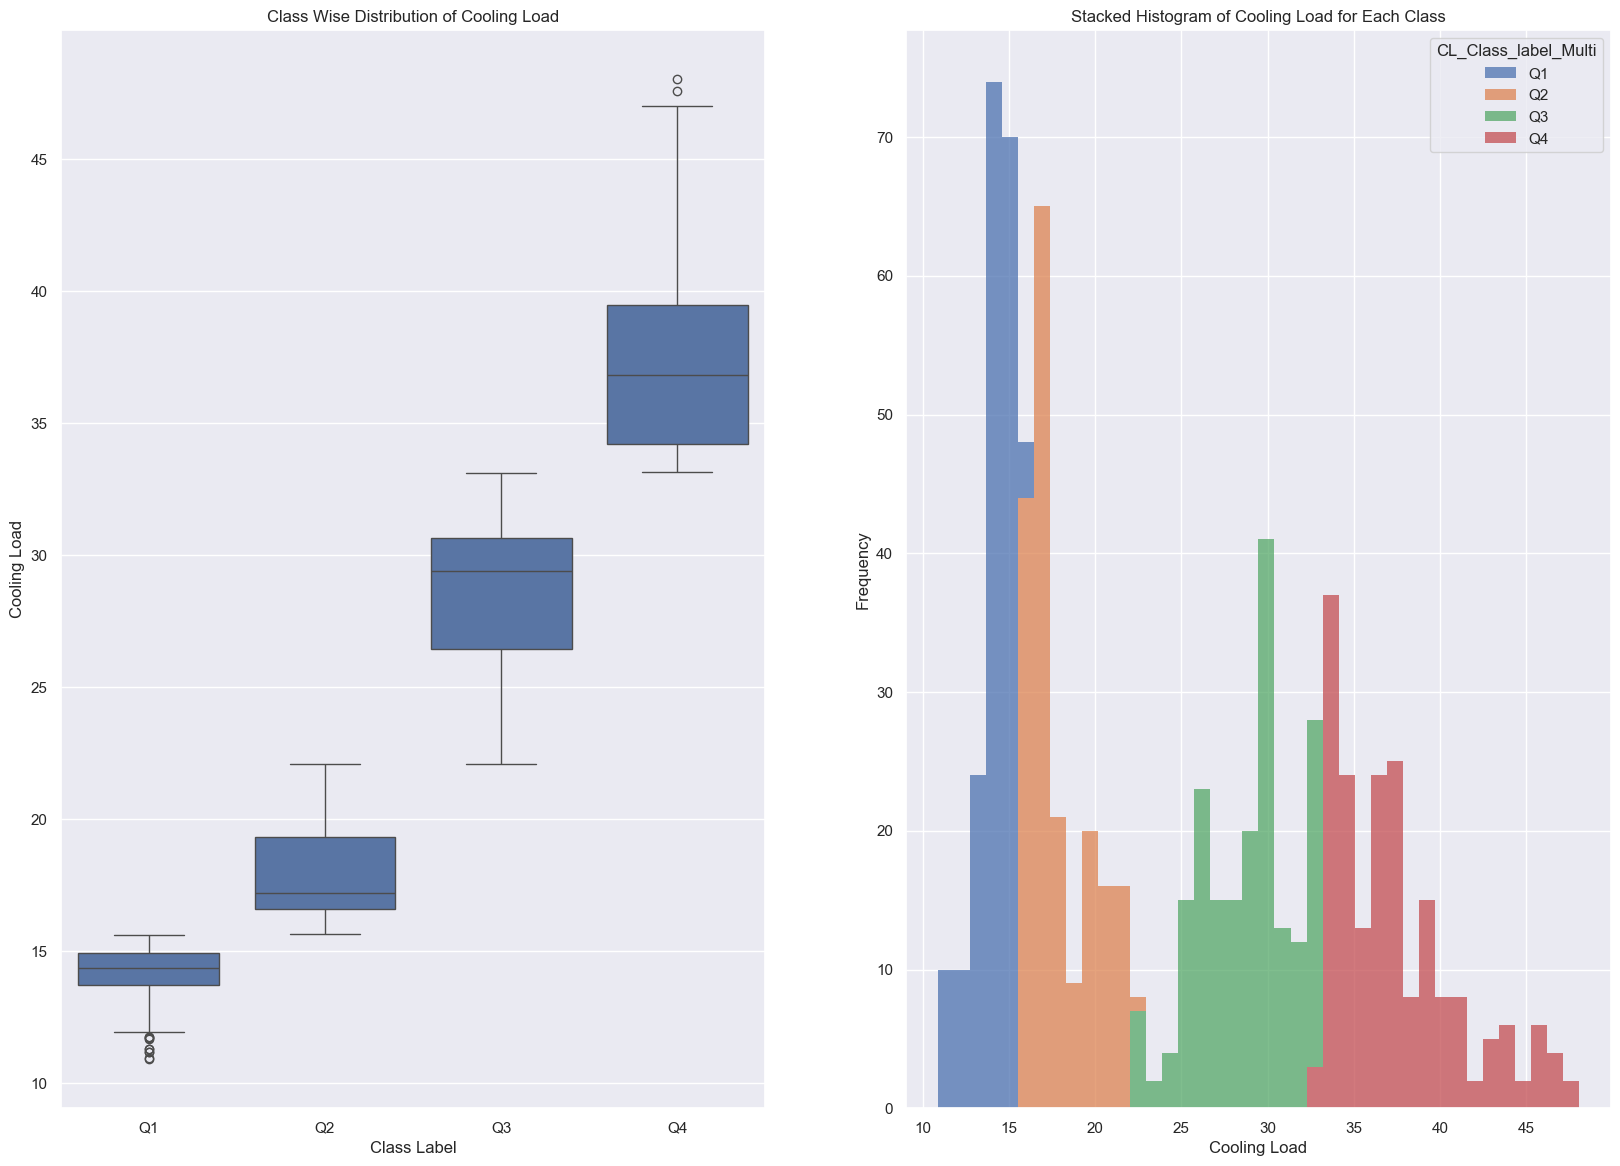

In [102]:
# plotting to observe distribution of Cooling load as per the multi-class classification rule used
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize=(20, 14))
sns.boxplot(x='CL_Class_label_Multi', y='COOLING LOAD', data=data_corr_cooling_multi, ax=axs[0])
axs[0].set_title('Class Wise Distribution of Cooling Load')
axs[0].set_xlabel('Class Label')
axs[0].set_ylabel('Cooling Load')


sns.histplot(data=data_corr_cooling_multi, x='COOLING LOAD', hue='CL_Class_label_Multi', multiple='stack', bins=40, linewidth=0, ax=axs[1])#, palette=['yellow', 'black', 'black','black'])
axs[1].set_title('Stacked Histogram of Cooling Load for Each Class')
axs[1].set_xlabel('Cooling Load')
axs[1].set_ylabel('Frequency')

Text(0.5, 1.0, 'Cooling Load Class Distribution')

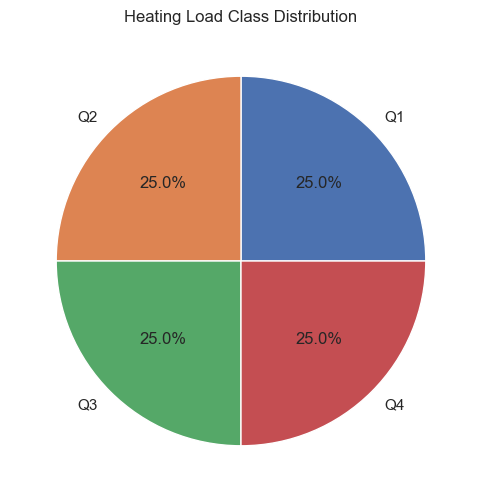

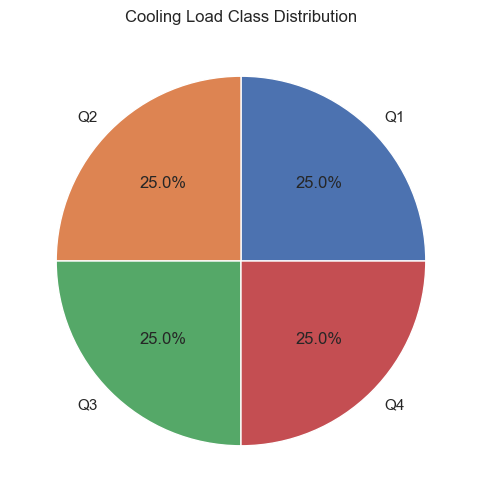

In [103]:
# plotting pie-chart for Multiclass problem
plt.figure(figsize=(6, 6))
palette_color = sns.color_palette('bright')
plt.pie(data_corr_heating_multi['HL_Class_Multi'].value_counts(), labels=data_corr_heating_multi['HL_Class_label_Multi'].value_counts().index, autopct='%1.1f%%')
plt.title('Heating Load Class Distribution')

plt.figure(figsize=(6, 6))
palette_color = sns.color_palette('bright')
plt.pie(data_corr_cooling_multi['CL_Class_Multi'].value_counts(), labels=data_corr_cooling_multi['CL_Class_label_Multi'].value_counts().index, autopct='%1.1f%%')
plt.title('Cooling Load Class Distribution')

#### ***Inference:*** *From the above plots, we can see that the data points of each class of Heating Load and Cooling Load is  evenly distributed, meaning that the data set is balanced.*

## **3. Machine Learning Models & Performance Assessment**

**There are in total 8 datasets to work with and
two feature selection approaches with 2 target variables and 2 classification approaches.**

We have used classification report and confusion matrix from sklearn to display the metrics for both binary and multiclass classification because avoid relying on a single metric (example: accuracy) and to give class wise performance of the approaches and the model.

Moreover, the confusion matrix provides a visual representation of how many instances were correctly classified (true positives and true negatives) and where the model made mistakes (false positives and false negatives).

The different models are as below -


### Training function

Note: Basically, 4 datasets for multiclass and binary each.
We pass dataset to the function called "Training" below, which extracts X and Y, then does a train test split followed by binary or multiclass feature creation (calling the function).

**We have called the binary and multiclass features separately for outer test and outer training dataset to avoid any data leakage that might otherwise seap into the training and cause flawed overview of the model performance.**

In [104]:
def training(dataset, func, dictionary):
  # In the above function, we pass the dataset to train, the classification feature creation function (binary or multiclass),
  # and the dictionary containing the different labels for the classification approaches for displaying class based metrics.
  # We use the Nested holdout validation method: we split into a outer train-test set and perform k-fold CV on the outer train test to train the model.
  X, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]
  X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(X, y, test_size=0.3, random_state=42, shuffle= True)#, stratify=y)

  # Creating the classifation target variables.
  y_train_outer_classify= func(y_train_outer)
  y_test_outer_classify= func(y_test_outer)

  # specifying k fold and hyperparameters dict
  kfold=KFold(n_splits=5, shuffle=True)
  param_grid = {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ('linear', 'rbf')}

  # make pipeline
  SVC_pipeline= Pipeline([
      ("scaler", MinMaxScaler(feature_range=(0,1))),
      ("classifier", SVC())
  ])

  # We use kfold CV in the GridsearchCV function because it perfectly encapsulates the model, hyperparameters for tuning
  # and the splliting strategy to use.
  inner_cv = GridSearchCV(estimator=SVC_pipeline, param_grid= param_grid, cv=kfold)
  inner_cv.fit(X_train_outer, y_train_outer_classify)
  best_params =inner_cv.best_params_

  # Display the best Hyperparameters and the classifcation report on the Outer train and test set.
  print(f'Best Hyperparameters: {best_params}')

  print('Report on Outer Train Set: ')
  print(classification_report(y_train_outer_classify, inner_cv.predict(X_train_outer), labels=list(dictionary.keys()), target_names=list(dictionary.values())))

  print(f'Report on Outer Test Set: ')
  print(classification_report(y_test_outer_classify, inner_cv.predict(X_test_outer), labels=list(dictionary.keys()), target_names=list(dictionary.values())))

  # We use Micro averaged F1 score as a metric to decide which approach is the best.
  report_f1= f1_score(y_test_outer_classify, inner_cv.predict(X_test_outer), average='micro')
  print("Micro F1 score:", report_f1)

  # Display a confusion matrix
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(confusion_matrix(y_test_outer_classify, inner_cv.predict(X_test_outer)), cmap=plt.cm.jet, square=True, annot=True, cbar=False, ax=ax, fmt=".0f");
  ax.set_xlabel('Predicted', fontsize=16)
  ax.set_ylabel('True', fontsize=16)
  ax.set_title('Confusion Matrix', fontsize=18)
  ax.set_xticklabels(list(dictionary.values()))
  ax.set_yticklabels(list(dictionary.values()))


### Binary Classification

Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Report on Outer Train Set: 
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       288
        High       1.00      1.00      1.00       249

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537

Report on Outer Test Set: 
              precision    recall  f1-score   support

         Low       1.00      0.98      0.99       114
        High       0.98      1.00      0.99       117

    accuracy                           0.99       231
   macro avg       0.99      0.99      0.99       231
weighted avg       0.99      0.99      0.99       231

Micro F1 score: 0.9913419913419913


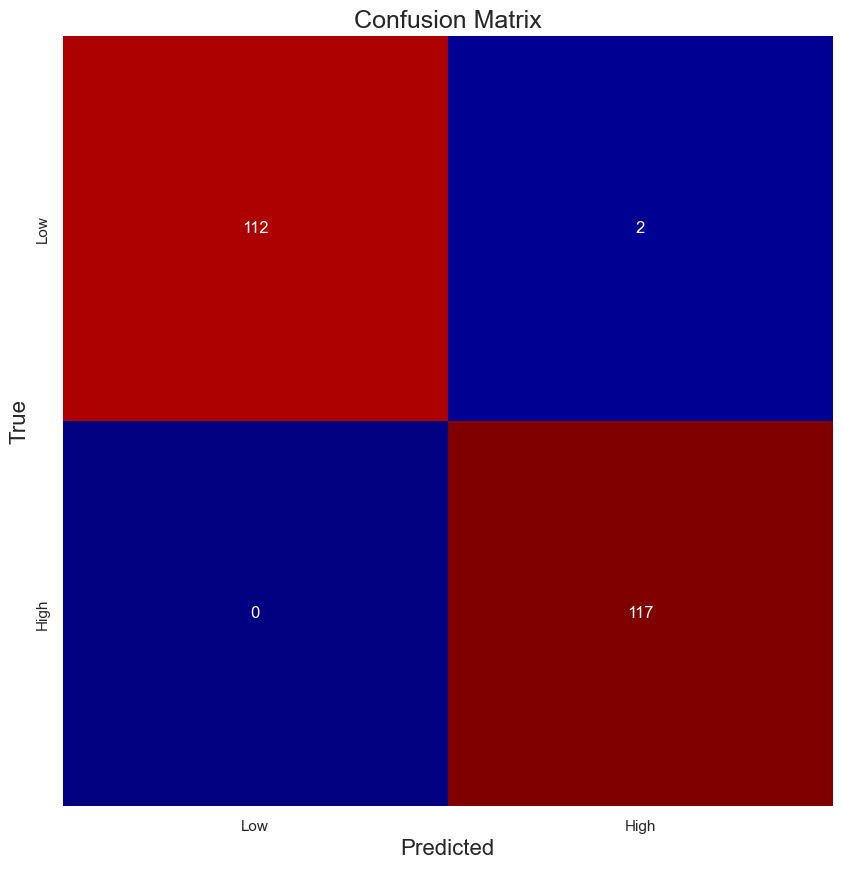

In [105]:
#Binary class classification For data with Correlation based feature selection

# For Heating Load
training(data_corr_heating, binary_classify, class_label_mapping_bin)

Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Report on Outer Train Set: 
              precision    recall  f1-score   support

         Low       1.00      0.99      0.99       283
        High       0.98      1.00      0.99       254

    accuracy                           0.99       537
   macro avg       0.99      0.99      0.99       537
weighted avg       0.99      0.99      0.99       537

Report on Outer Test Set: 
              precision    recall  f1-score   support

         Low       1.00      0.96      0.98       114
        High       0.96      1.00      0.98       117

    accuracy                           0.98       231
   macro avg       0.98      0.98      0.98       231
weighted avg       0.98      0.98      0.98       231

Micro F1 score: 0.9783549783549783


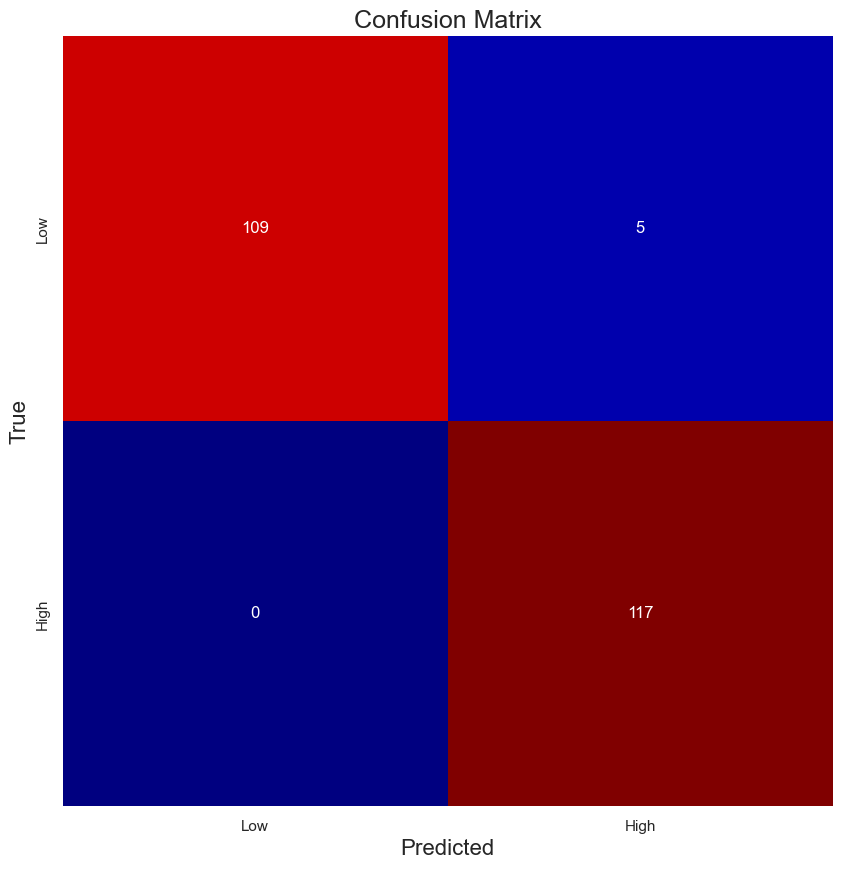

In [106]:
#Binary class classification For data with Correlation based feature selection

# For Cooling Load
training(data_corr_cooling, binary_classify, class_label_mapping_bin)

Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Report on Outer Train Set: 
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       288
        High       1.00      1.00      1.00       249

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537

Report on Outer Test Set: 
              precision    recall  f1-score   support

         Low       1.00      0.98      0.99       114
        High       0.98      1.00      0.99       117

    accuracy                           0.99       231
   macro avg       0.99      0.99      0.99       231
weighted avg       0.99      0.99      0.99       231

Micro F1 score: 0.9913419913419913


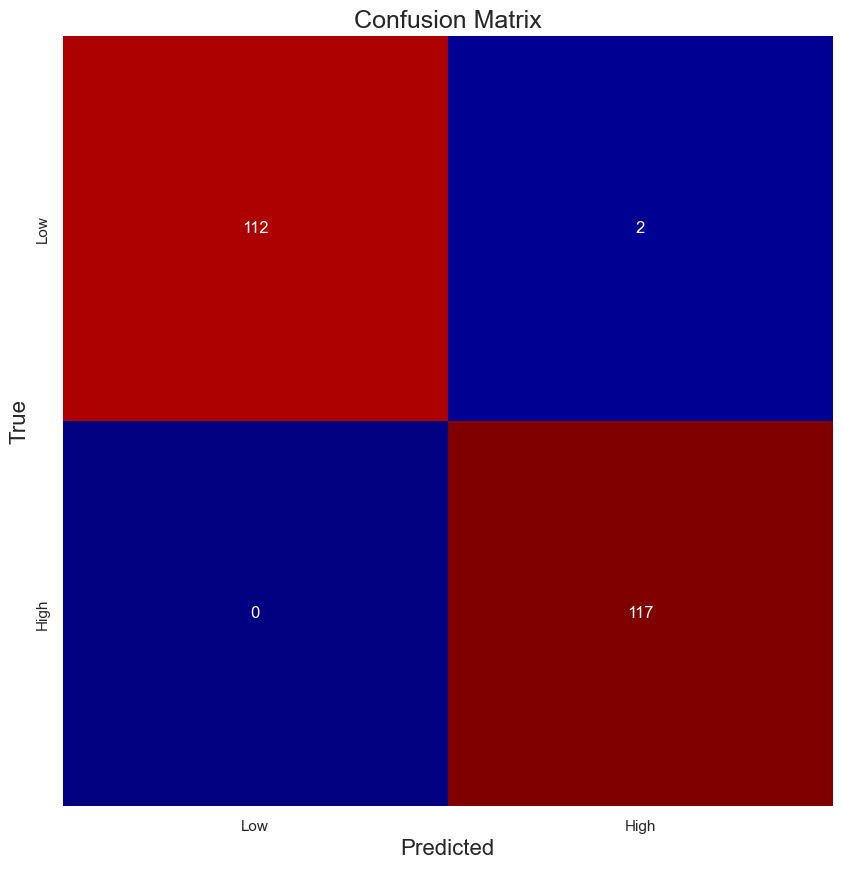

In [107]:
#Binary class classification For data with Backward stepwise based feature selection

# For Heating Load
training(data_stepwise_heating, binary_classify, class_label_mapping_bin)

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
Report on Outer Train Set: 
              precision    recall  f1-score   support

         Low       1.00      0.98      0.99       283
        High       0.97      1.00      0.99       254

    accuracy                           0.99       537
   macro avg       0.99      0.99      0.99       537
weighted avg       0.99      0.99      0.99       537

Report on Outer Test Set: 
              precision    recall  f1-score   support

         Low       1.00      0.95      0.97       114
        High       0.95      1.00      0.97       117

    accuracy                           0.97       231
   macro avg       0.98      0.97      0.97       231
weighted avg       0.98      0.97      0.97       231

Micro F1 score: 0.974025974025974


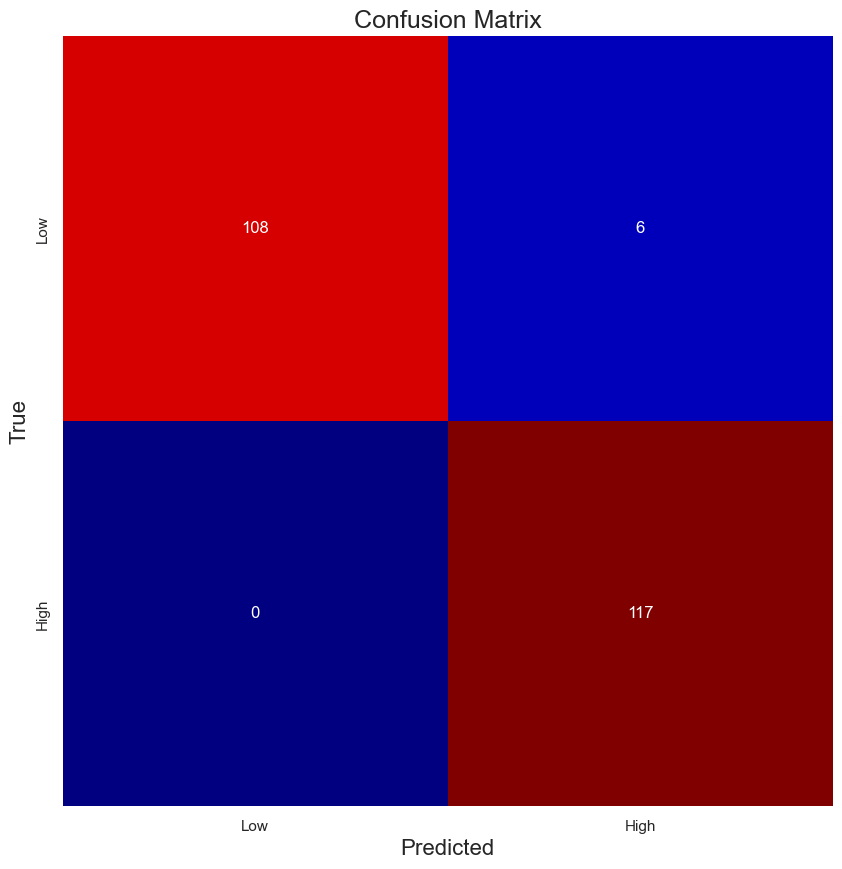

In [108]:
#Binary class classification For data with Backward stepwise based feature selection

# For Cooling Load
training(data_stepwise_cooling, binary_classify, class_label_mapping_bin)

#### ***Inference:*** *The confusion matrix and the classification metrics show a very high precision, recall and F1 score for binary classifcation for both training and test set.*

### Multiclass Classification

The quantiles are:  [ 6.01 12.96 17.23 31.28 43.1 ]
The quantiles are:  [ 6.07  13.175 23.67  32.19  42.96 ]
Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Report on Outer Train Set: 
              precision    recall  f1-score   support

          Q1       0.88      0.84      0.86       135
          Q2       0.77      0.87      0.82       134
          Q3       0.97      0.78      0.86       134
          Q4       0.89      1.00      0.94       134

    accuracy                           0.87       537
   macro avg       0.88      0.87      0.87       537
weighted avg       0.88      0.87      0.87       537

Report on Outer Test Set: 
              precision    recall  f1-score   support

          Q1       0.89      0.84      0.87        58
          Q2       0.83      0.78      0.80        58
          Q3       0.87      0.81      0.84        57
          Q4       0.84      1.00      0.91        58

    accuracy                           0.86       231
  

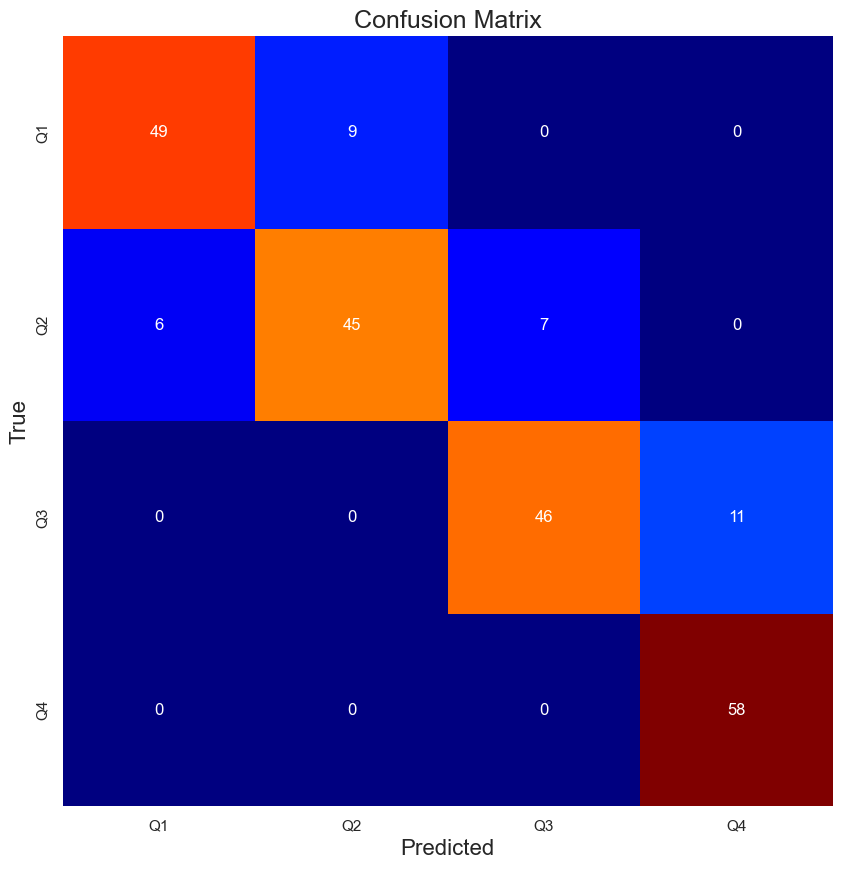

In [109]:
#Multiclass classification For data with Correlation based feature selection

# For Heating Load
training(data_corr_heating, multi_classify, class_label_mapping_multi)

The quantiles are:  [10.94 15.5  21.16 32.92 48.03]
The quantiles are:  [10.9   16.005 25.63  33.7   46.44 ]
Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Report on Outer Train Set: 
              precision    recall  f1-score   support

          Q1       0.82      0.90      0.86       135
          Q2       0.84      0.80      0.82       134
          Q3       0.82      0.92      0.87       135
          Q4       0.97      0.80      0.88       133

    accuracy                           0.86       537
   macro avg       0.86      0.86      0.86       537
weighted avg       0.86      0.86      0.86       537

Report on Outer Test Set: 
              precision    recall  f1-score   support

          Q1       0.88      0.84      0.86        58
          Q2       0.83      0.74      0.78        58
          Q3       0.71      0.86      0.78        57
          Q4       0.85      0.79      0.82        58

    accuracy                           0.81       231
  

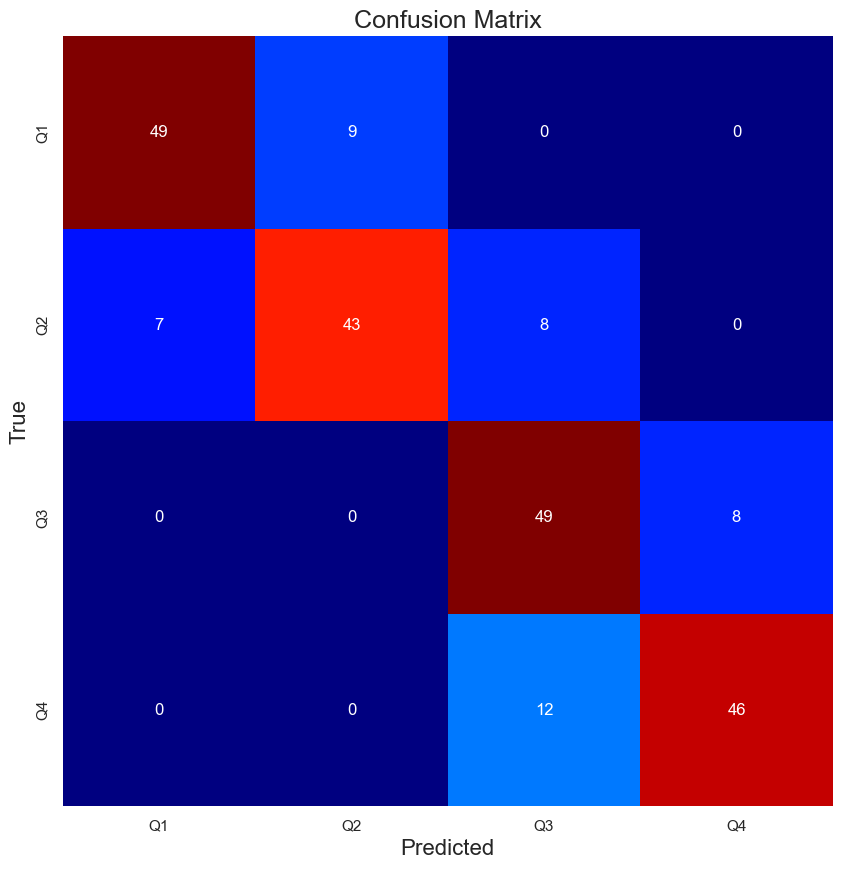

In [110]:
#Multiclass classification For data with Correlation based feature selection

# For Cooling Load
training(data_corr_cooling, multi_classify, class_label_mapping_multi)

The quantiles are:  [ 6.01 12.96 17.23 31.28 43.1 ]
The quantiles are:  [ 6.07  13.175 23.67  32.19  42.96 ]
Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Report on Outer Train Set: 
              precision    recall  f1-score   support

          Q1       0.94      0.89      0.91       135
          Q2       0.81      0.92      0.86       134
          Q3       0.95      0.80      0.87       134
          Q4       0.90      0.98      0.94       134

    accuracy                           0.90       537
   macro avg       0.90      0.90      0.90       537
weighted avg       0.90      0.90      0.90       537

Report on Outer Test Set: 
              precision    recall  f1-score   support

          Q1       0.96      0.90      0.93        58
          Q2       0.89      0.84      0.87        58
          Q3       0.85      0.82      0.84        57
          Q4       0.85      0.98      0.91        58

    accuracy                           0.89       231
  

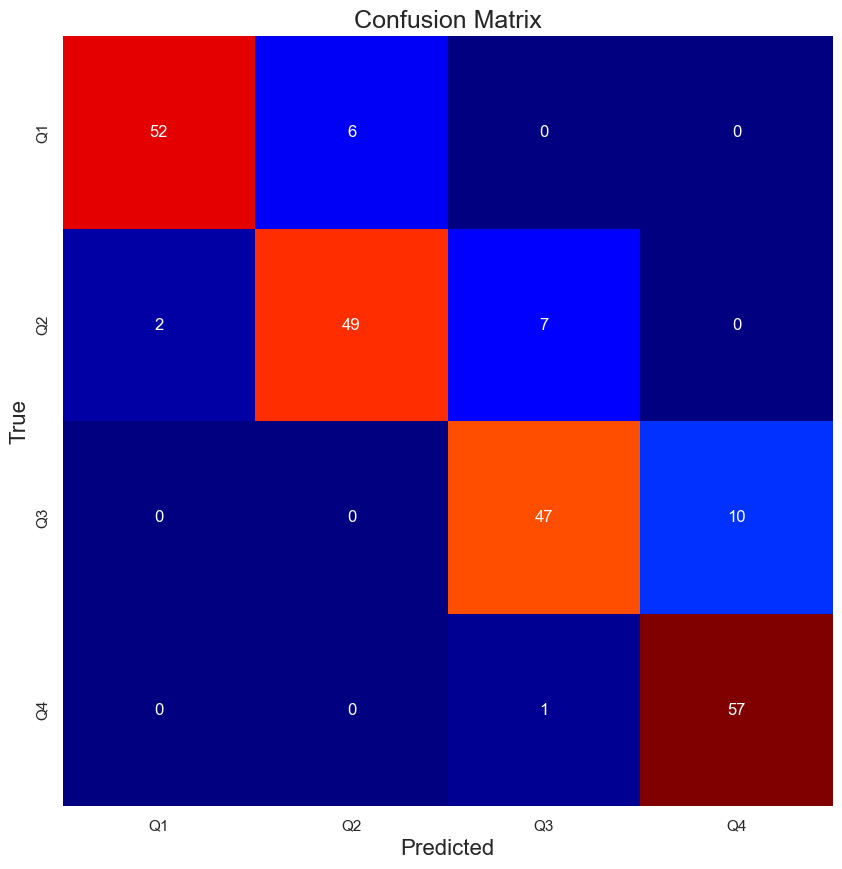

In [111]:
#Multiclass classification For data with Backward stepwise based feature selection

# For Heating Load
training(data_stepwise_heating, multi_classify, class_label_mapping_multi)

The quantiles are:  [10.94 15.5  21.16 32.92 48.03]
The quantiles are:  [10.9   16.005 25.63  33.7   46.44 ]
Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Report on Outer Train Set: 
              precision    recall  f1-score   support

          Q1       0.85      0.84      0.84       135
          Q2       0.79      0.84      0.82       134
          Q3       0.83      0.91      0.87       135
          Q4       0.96      0.81      0.88       133

    accuracy                           0.85       537
   macro avg       0.86      0.85      0.85       537
weighted avg       0.86      0.85      0.85       537

Report on Outer Test Set: 
              precision    recall  f1-score   support

          Q1       0.87      0.81      0.84        58
          Q2       0.80      0.74      0.77        58
          Q3       0.71      0.84      0.77        57
          Q4       0.84      0.79      0.81        58

    accuracy                           0.80       231
  

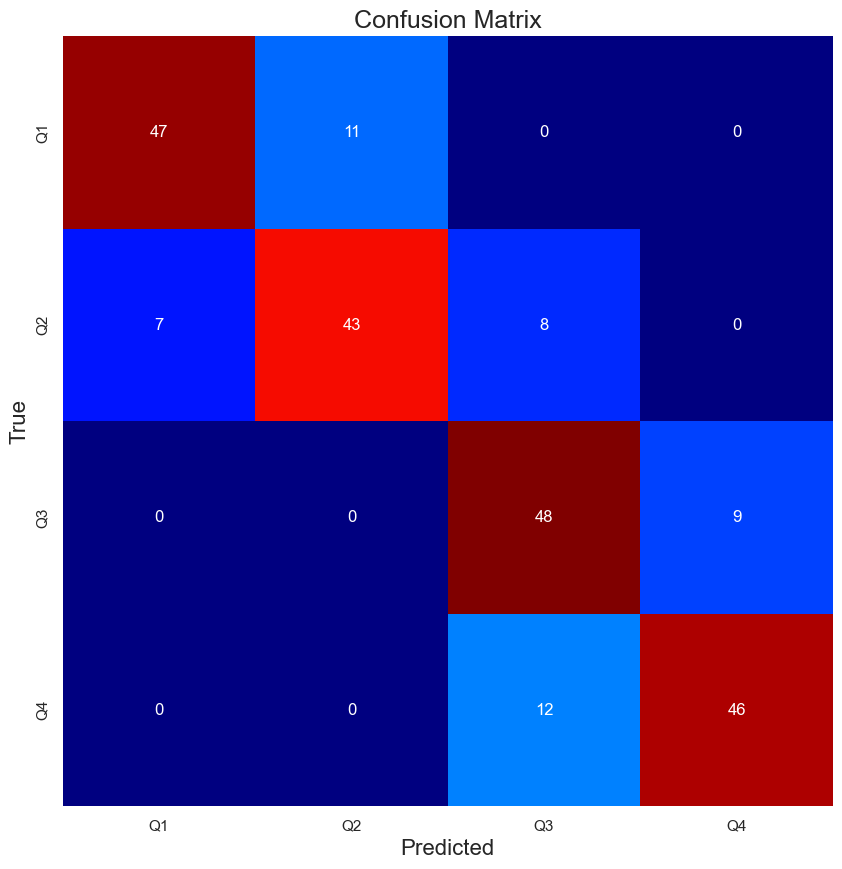

In [112]:
# Multiclass classification For data with Backward stepwise based feature selection

# For Cooling Load
training(data_stepwise_cooling, multi_classify, class_label_mapping_multi)

#### ***Inference:*** *The confusion matrix and the multiclass classification metrics show lower precision, recall and F1 score as compared to binary classification for both training and test set.*

## **4. Conclusion and Future Developments**

Below, we have displayed the table wise "*micro-averaged F1 score*" for each approach we have taken. We have selected this particuar metric as the metric for comparison, because F1 score is the harmonic mean of precision and recall (a **combination of 2 important classification metrics**) thus being the best candidate if we had to use a single metric to compare our different methodologies. Furthermore, we have taken micro-average of F1 score over all classes because micro-averaging gives equal weight to each datapoint regardless of the class label and is recommended for measuring the **overall performance.**

### Test Data Micro F1 Score summary table for Binary Classification



| Target Variable| Feature Selection Method| F1 Score |
|--------------|--------------|--------------|
| Heating Load| Correlation Method| 0.99|
|| Backward Stepwise Method| 0.97|
|Cooling Load| Correlation Method|  0.99|
| | Backward Stepwise Method|  0.97|

#### ***Inference:*** *We see that both the feature selection methods give similar and very high performance for the given dataset on both the target variables. This is most likely due to the following factors:*

1. Very high correlation between the selected features and the target variables.
2. The dataset is not big enough and does not have high variance to generalize well. This might also lead to any production data having worse
classification performance.
3. A binary classification problem requires less decision space, hence easier for the model to explore and learn the structure leading to higher F1 score.

### Test Data Micro F1 Score summary table for Multiclass Classification



| Target Variable| Feature Selection Method| F1 Score |
|--------------|--------------|--------------|
| Heating Load| Correlation Method| 0.86|
|| Backward Stepwise Method| 0.89|
|Cooling Load| Correlation Method|  0.81|
| | Backward Stepwise Method|  0.79|

#### ***Inference:*** *We see that both feature selection methods give higher performance for heating load as compared to cooling load and have overall lesser F1 score as compared to Binary classification. These observations are likely due to:*

1. Heating load has more efficient interactions with some of the variables leading to higher classification performance, as suggested by Tsanas et. al., 2012.
2. As mentioned earlier, binary classification has lesser decision space to explore as compared to multiclass classification. Thus multiclass classification models, especially given the smaller dataset, will not be able to learn the patterns and structure of the given dataset as good as a binary classification model.

### **Final approach to select**

1. Given the metrics, **correlation method** gives a fairly high micro-averaged F1 score for both heating load and cooling load for both the classification approaches. Given its simplicity and performance, it should be the chosen method for this experiment.
2. Even though binary classification leads to better results in this experiment, from an engineering and nuance perspective, **multiclass classification** seems like the approach to take. This is due to the fact that it discretizes the target variable into more categories, which seems imperative for such a engineering challenge.

### **Future Development**:
1. Dataset is fairly limited and too discrete since it is artificially generated. Having a dataset with higher variance in the predictors and target variables along with a larger size will help the model generalize well. Moreover, the simulated dataset will not be consistent with the real world data since it is generated based on underlying assumptions and simplifications which doesn't reflect what happens in the buildings in the real world.
2. Usage of a more complex model will help in exploring the decision space better, especially in case of multiclass classification which is more likely to be business requirement given the nuances of heating and cooling operations of a building.
3. More input and output variables can be incorporated, based on engineering perspectives to design heating and cooling systems which not only have a high energy efficiency, but also provide ambient indoor atmosphere in this ever changing climate.